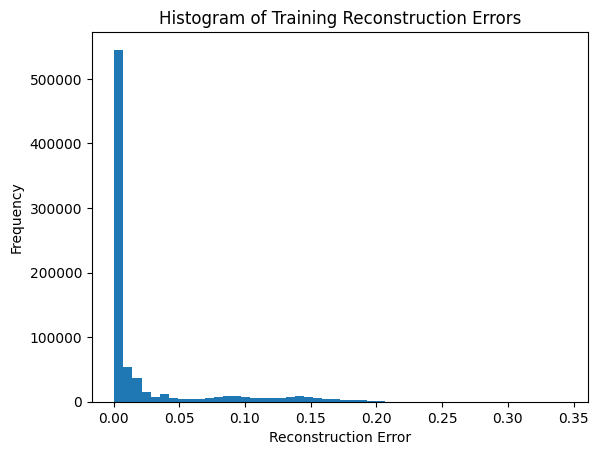

Min training error: 0.0006895752
Max training error: 0.34376946
Mean training error: 0.023004675016004953
99th percentile: 0.1801078094


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

train_errors_df = pd.read_csv("/Users/User2/Downloads/tadgan_train_errors_v17.csv")
train_errors = train_errors_df['train_errors']

plt.hist(train_errors, bins=50)
plt.title('Histogram of Training Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print stats
print("Min training error:", train_errors.min())
print("Max training error:", train_errors.max())
print("Mean training error:", train_errors.mean())
print("99th percentile:", np.percentile(train_errors, 99))

Starting TadGAN Hybrid Dynamic Threshold post-analysis...
Loading trained generator...
Test data shape: (9998, 15, 285)
all_errors shape = (9998, 15, 285)
Feature means (first 10): [3.8767457e-03 2.8656799e-04 5.7988864e-04 6.9003773e-04 6.0897809e-04
 3.2722918e-04 3.6971376e-03 3.8767466e-03 1.8267843e-05 2.2209164e-08]
Feature stds (first 10): [1.41641796e-02 7.72931788e-04 1.49088586e-03 1.34116050e-03
 7.99771340e-04 5.43767586e-04 1.31506966e-02 1.41641805e-02
 3.04998466e-05 1.40460983e-07]
Feature thresholds (first 10): [4.6369284e-02 2.6053633e-03 5.0525460e-03 4.7135195e-03 3.0082921e-03
 1.9585320e-03 4.3149229e-02 4.6369288e-02 1.0976738e-04 4.4359211e-07]

Sample sequence errors (first feature): [5.6840092e-02 1.2943879e-03 2.4465799e-05 4.5012007e-07 8.2514475e-09
 1.5223023e-10 2.7853275e-12 5.6843419e-14 3.5527137e-15 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.5527137e-15 0.0000000e+00 3.1974423e-14]
Threshold for first feature: 0.046369284
Total sequences: 9998
Anoma

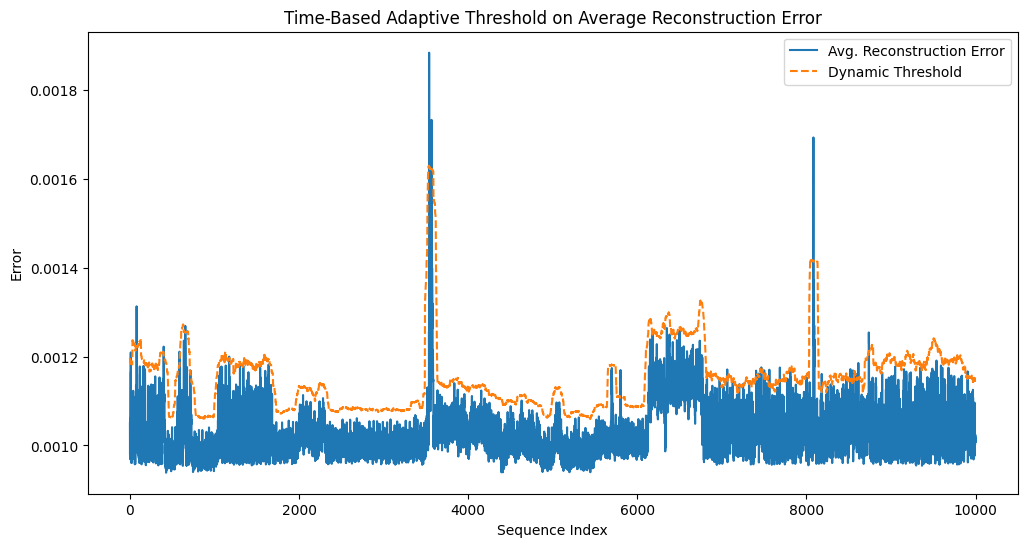

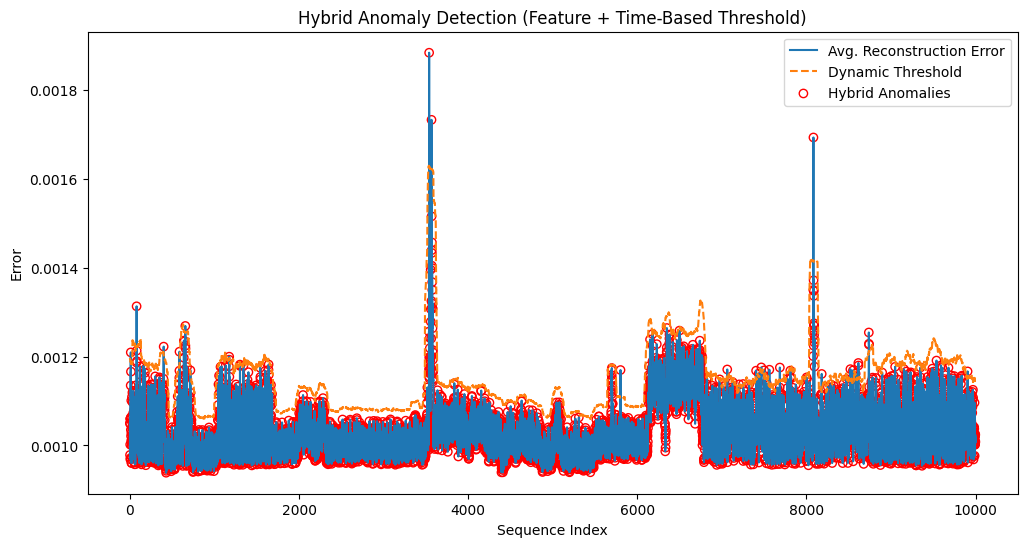

Hybrid dynamic thresholding complete.


In [2]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# -------------------------------
# 1) Basic setup
# -------------------------------
print("Starting TadGAN Hybrid Dynamic Threshold post-analysis...", flush=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters (adjust as desired)
seq_len = 15
input_dim = 285  # must match your training script
batch_size = 16

# Rolling window and factors for thresholds
rolling_window = 50   # half-window size for time-based threshold
k_time = 3.0          # factor for time-based threshold
k_feature = 3.0       # factor for per-feature threshold

# -------------------------------
# 2) Load trained generator
# -------------------------------
class Generator(torch.nn.Module):
    def __init__(self, input_dim, latent_dim=128):
        super().__init__()
        self.encoder = torch.nn.LSTM(input_dim, latent_dim, batch_first=True)
        self.decoder = torch.nn.LSTM(latent_dim, input_dim, batch_first=True)
        
    def forward(self, x):
        latent, _ = self.encoder(x)
        return self.decoder(latent)[0]

print("Loading trained generator...", flush=True)
gen = Generator(input_dim).to(device)
gen.load_state_dict(torch.load("/Users/User2/Downloads/tadgan_gen_v17.pth"))  # or v17 if you prefer
gen.eval()

# -------------------------------
# 3) Load test data
# -------------------------------
data_path = "/Users/User2/Desktop/Research Seminar/timegan_processed_data.csv"
full_data = pd.read_csv(data_path).iloc[:50000].values.astype(np.float32)
sequences = np.array(
    [full_data[i:i+seq_len] for i in range(len(full_data)-seq_len+1)],
    dtype=np.float32
)

# Last 20% as test data
split_idx = int(len(sequences) * 0.8)
test_data = sequences[split_idx:]

test_tensor = torch.tensor(test_data).float().to(device)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

print(f"Test data shape: {test_data.shape}", flush=True)

# -------------------------------
# 4) Compute reconstruction errors (per-feature)
# -------------------------------
# We'll store an array of shape (N, seq_len, input_dim)
all_errors = []

with torch.no_grad():
    for (batch,) in test_loader:
        real = batch.to(device)                     # (B, seq_len, input_dim)
        fake = gen(real)                            # (B, seq_len, input_dim)
        # MSE per element: shape (B, seq_len, input_dim)
        mse = (fake - real) ** 2
        all_errors.append(mse.cpu().numpy())

# Concatenate all batches
all_errors = np.concatenate(all_errors, axis=0)  # shape (N, seq_len, input_dim)
N = all_errors.shape[0]
print(f"all_errors shape = {all_errors.shape}")

# -------------------------------
# 5) Feature-Wise Threshold
# -------------------------------
# Flatten along time and samples for each feature
# shape => (N*seq_len, input_dim)
flattened = all_errors.reshape(-1, input_dim)

# Compute mean & std for each feature
feature_means = np.mean(flattened, axis=0)   # shape (input_dim,)
feature_stds  = np.std(flattened, axis=0)    # shape (input_dim,)

feature_thresholds = feature_means + k_feature * feature_stds  # shape (input_dim,)

# We'll create a boolean mask for each sample (N) 
# that says whether ANY feature in that sample exceeds its threshold.
feature_anomalies = np.zeros(N, dtype=bool)

# DEBUGGING VALUES
print("Feature means (first 10):", feature_means[:10])
print("Feature stds (first 10):", feature_stds[:10])
print("Feature thresholds (first 10):", feature_thresholds[:10])

# Check a sample sequence
print("\nSample sequence errors (first feature):", all_errors[0, :, 0])
print("Threshold for first feature:", feature_thresholds[0])


for i in range(N):
    # shape (seq_len, input_dim)
    seq_error = all_errors[i]
    # Check if any feature's error in the sequence is above that feature's threshold
    # We'll broadcast so that thresholds (1, input_dim) matches seq_error
    above_thresh = seq_error > feature_thresholds
    if np.any(above_thresh):
        feature_anomalies[i] = True

# -------------------------------
# 6) Time-Based Adaptive Threshold on Average Error
# -------------------------------
# We'll first compute the average error across all features (and time steps) for each sequence.
# shape => (N, )
avg_seq_error = np.mean(all_errors, axis=(1,2))  # mean over seq_len and input_dim

# We'll create a rolling mean + std for each index in [0...N-1].
# For index i, we look at [i-rolling_window : i+rolling_window]
# Then threshold = mean + k_time*std in that window.
time_anomalies = np.zeros(N, dtype=bool)
window = rolling_window

def rolling_stats(data, index, window):
    """
    Returns mean and std of data in range [index-window, index+window], clipped to boundaries.
    """
    left = max(0, index - window)
    right = min(len(data), index + window + 1)
    window_slice = data[left:right]
    return np.mean(window_slice), np.std(window_slice)

time_thresholds = np.zeros(N)

for i in range(N):
    mu_i, std_i = rolling_stats(avg_seq_error, i, window)
    thresh_i = mu_i + k_time * std_i
    time_thresholds[i] = thresh_i
    
    if avg_seq_error[i] > thresh_i:
        time_anomalies[i] = True

# -------------------------------
# 7) Hybrid Decision
# -------------------------------
# We'll say a sequence is anomalous if EITHER feature_anomalies[i] OR time_anomalies[i] is True.
hybrid_anomalies = feature_anomalies | time_anomalies

print(f"Total sequences: {N}")
print(f"Anomalies (feature-based): {feature_anomalies.sum()} ({feature_anomalies.mean()*100:.2f}%)")
print(f"Anomalies (time-based): {time_anomalies.sum()} ({time_anomalies.mean()*100:.2f}%)")
print(f"Anomalies (hybrid): {hybrid_anomalies.sum()} ({hybrid_anomalies.mean()*100:.2f}%)")

# -------------------------------
# 8) Plotting
# -------------------------------
# (A) Plot the average reconstruction error over time + dynamic threshold
plt.figure(figsize=(12,6))
plt.plot(avg_seq_error, label='Avg. Reconstruction Error')
plt.plot(time_thresholds, label='Dynamic Threshold', linestyle='--')
plt.title("Time-Based Adaptive Threshold on Average Reconstruction Error")
plt.xlabel("Sequence Index")
plt.ylabel("Error")
plt.legend()
plt.show()

# (B) Mark anomalies on the same plot (optional)
plt.figure(figsize=(12,6))
plt.plot(avg_seq_error, label='Avg. Reconstruction Error')
plt.plot(time_thresholds, label='Dynamic Threshold', linestyle='--')
# highlight sequences flagged by the hybrid method
anomaly_indices = np.where(hybrid_anomalies)[0]
plt.scatter(anomaly_indices, avg_seq_error[anomaly_indices], 
            marker='o', facecolors='none', edgecolors='r', label='Hybrid Anomalies')
plt.title("Hybrid Anomaly Detection (Feature + Time-Based Threshold)")
plt.xlabel("Sequence Index")
plt.ylabel("Error")
plt.legend()
plt.show()

print("Hybrid dynamic thresholding complete.")


Starting TadGAN Time-Based Anomaly Detection...
Loading trained generator...
Test data shape: (9998, 15, 285)
all_errors shape = (9998, 15, 285)
Total sequences: 9998
Anomalies (time-based): 31 (0.31%)


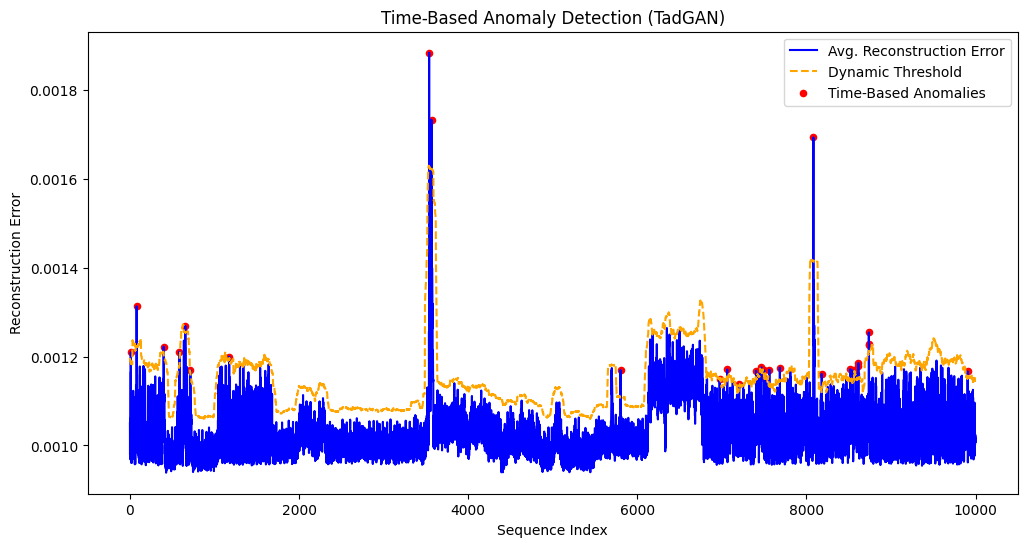

Time-based anomaly detection complete ✅


In [3]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# -------------------------------
# 1) Basic setup
# -------------------------------
print("Starting TadGAN Time-Based Anomaly Detection...", flush=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
seq_len = 15
input_dim = 285  # Must match training script
batch_size = 16

# Rolling window and factor for time-based threshold
rolling_window = 50
k_time = 3.0  # Factor for time-based threshold sensitivity

# -------------------------------
# 2) Load trained generator
# -------------------------------
class Generator(torch.nn.Module):
    def __init__(self, input_dim, latent_dim=128):
        super().__init__()
        self.encoder = torch.nn.LSTM(input_dim, latent_dim, batch_first=True)
        self.decoder = torch.nn.LSTM(latent_dim, input_dim, batch_first=True)
        
    def forward(self, x):
        latent, _ = self.encoder(x)
        return self.decoder(latent)[0]

print("Loading trained generator...", flush=True)
gen = Generator(input_dim).to(device)
gen.load_state_dict(torch.load("/Users/User2/Downloads/tadgan_gen_v17.pth"))
gen.eval()

# -------------------------------
# 3) Load test data
# -------------------------------
data_path = "/Users/User2/Desktop/Research Seminar/timegan_processed_data.csv"
full_data = pd.read_csv(data_path).iloc[:50000].values.astype(np.float32)
sequences = np.array(
    [full_data[i:i + seq_len] for i in range(len(full_data) - seq_len + 1)],
    dtype=np.float32
)

# Last 20% as test data
split_idx = int(len(sequences) * 0.8)
test_data = sequences[split_idx:]

test_tensor = torch.tensor(test_data).float().to(device)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

print(f"Test data shape: {test_data.shape}", flush=True)

# -------------------------------
# 4) Compute reconstruction errors (for time-based)
# -------------------------------
all_errors = []
with torch.no_grad():
    for (batch,) in test_loader:
        real = batch.to(device)
        fake = gen(real)
        mse = (fake - real) ** 2
        all_errors.append(mse.cpu().numpy())

# Concatenate all batches into shape (N, seq_len, input_dim)
all_errors = np.concatenate(all_errors, axis=0)  # shape (N, seq_len, input_dim)
N = all_errors.shape[0]
print(f"all_errors shape = {all_errors.shape}")

# Compute average error across time steps and features (mean over seq_len and input_dim)
avg_seq_error = np.mean(all_errors, axis=(1, 2))

# -------------------------------
# 5) Time-Based Adaptive Thresholding
# -------------------------------
time_thresholds = np.zeros(N)

def rolling_stats(data, index, window):
    left = max(0, index - window)
    right = min(len(data), index + window + 1)
    window_slice = data[left:right]
    return np.mean(window_slice), np.std(window_slice)

time_anomalies = np.zeros(N, dtype=bool)

for i in range(N):
    mu_i, std_i = rolling_stats(avg_seq_error, i, rolling_window)
    thresh_i = mu_i + k_time * std_i
    time_thresholds[i] = thresh_i
    
    if avg_seq_error[i] > thresh_i:
        time_anomalies[i] = True

# -------------------------------
# 6) Results Summary
# -------------------------------
print(f"Total sequences: {N}")
print(f"Anomalies (time-based): {time_anomalies.sum()} ({time_anomalies.mean() * 100:.2f}%)")

# -------------------------------
# 7) Plotting (Time-Based Only)
# -------------------------------
plt.figure(figsize=(12, 6))
plt.plot(avg_seq_error, label='Avg. Reconstruction Error', color='blue')
plt.plot(time_thresholds, label='Dynamic Threshold', linestyle='--', color='orange')

# Mark anomalies
anomaly_indices = np.where(time_anomalies)[0]
plt.scatter(anomaly_indices, avg_seq_error[anomaly_indices],
            color='red', label='Time-Based Anomalies', s=20)

plt.title("Time-Based Anomaly Detection (TadGAN)")
plt.xlabel("Sequence Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

print("Time-based anomaly detection complete ✅", flush=True)


In [6]:
import numpy as np

# Suppose 'time_anomalies' is your boolean array from the time-based detection, shape (9998,)
# 'seq_len' = 15
# 'total_sequences' = 49986 ( = 50000 - 15 + 1 )
# 'test_start_seq' = int(0.8 * total_sequences) = 39988

seq_len = 15
total_sequences = 50000 - seq_len + 1  # 49986
test_start_seq = int(total_sequences * 0.8)  # 39988

# time_anomalies is shape (9998,), each entry True/False
anomaly_seq_indices = np.where(time_anomalies)[0]  # local indices in [0..9997]
print(f"Found {len(anomaly_seq_indices)} anomalous sequences in the test set")

# Map local test sequence indices to global sequence indices
global_anomaly_seq_indices = test_start_seq + anomaly_seq_indices

# For each anomalous sequence, figure out which rows in the original data are involved
for local_seq, global_seq in zip(anomaly_seq_indices, global_anomaly_seq_indices):
    start_row = global_seq
    end_row = global_seq + seq_len - 1
    print(f"Test seq {local_seq} => Global seq {global_seq} => Rows {start_row}..{end_row} in original data")

Found 31 anomalous sequences in the test set
Test seq 10 => Global seq 39998 => Rows 39998..40012 in original data
Test seq 79 => Global seq 40067 => Rows 40067..40081 in original data
Test seq 399 => Global seq 40387 => Rows 40387..40401 in original data
Test seq 586 => Global seq 40574 => Rows 40574..40588 in original data
Test seq 655 => Global seq 40643 => Rows 40643..40657 in original data
Test seq 715 => Global seq 40703 => Rows 40703..40717 in original data
Test seq 1174 => Global seq 41162 => Rows 41162..41176 in original data
Test seq 3538 => Global seq 43526 => Rows 43526..43540 in original data
Test seq 3566 => Global seq 43554 => Rows 43554..43568 in original data
Test seq 5801 => Global seq 45789 => Rows 45789..45803 in original data
Test seq 6973 => Global seq 46961 => Rows 46961..46975 in original data
Test seq 7063 => Global seq 47051 => Rows 47051..47065 in original data
Test seq 7204 => Global seq 47192 => Rows 47192..47206 in original data
Test seq 7404 => Global seq

In [24]:
import numpy as np
import pandas as pd

# --- Assume the following variables are already computed from your post-analysis ---
# all_errors: NumPy array of shape (N, seq_len, input_dim) for the test set.
# time_anomalies: boolean array of length N indicating time-based anomalies.
# test_start_seq: global sequence index where the test set starts.
# For example:
#    seq_len = 15
#    total_sequences = 50000 - 15 + 1
#    test_start_seq = int(total_sequences * 0.8)
#
# In your case, all_errors comes from your test_loader processing,
# and time_anomalies was computed via your rolling window threshold logic.

# For our fixed feature threshold, we use all test sequences.
# Flatten errors along the time dimension to get per-feature errors.
# Note: Here we assume that all_errors corresponds solely to the test set.
N, seq_len, input_dim = all_errors.shape  # N = number of test sequences
k_feature = 1.0

# Compute global per-feature threshold using Median Absolute Deviation (MAD)
flattened = all_errors.reshape(-1, input_dim)  # shape (N*seq_len, input_dim)
median_features = np.median(flattened, axis=0)
mad_features = np.median(np.abs(flattened - median_features), axis=0)
# k_feature is a scaling factor (e.g., 2.0)
fixed_feature_thresholds = median_features + k_feature * mad_features

print("Fixed per-feature thresholds:")
print(fixed_feature_thresholds)

# Now, for each anomalous sequence (detected by time-based detector),
# compute the average reconstruction error per feature and compare it with fixed_feature_thresholds.
anomalous_seq_local_indices = np.where(time_anomalies)[0]  # indices within test set
print(f"Found {len(anomalous_seq_local_indices)} anomalous sequences in the test set (time-based).")

# Dictionary to hold results: key = global sequence index, value = array of anomalous feature indices.
anomalous_features_fixed = {}

# If you want to report global sequence indices, use:
# global_anomaly_seq_indices = test_start_seq + anomalous_seq_local_indices
# (If you want local indices only, you can keep anomalous_seq_local_indices.)

for local_idx in anomalous_seq_local_indices:
    # Compute per-feature average error for this sequence (shape: (input_dim,))
    seq_error = all_errors[local_idx]            # shape (seq_len, input_dim)
    mean_error_per_feature = np.mean(seq_error, axis=0)
    
    # Determine which features exceed the fixed threshold.
    bad_features = np.where(mean_error_per_feature > fixed_feature_thresholds)[0]
    
    # Map to global sequence index if needed:
    global_idx = test_start_seq + local_idx
    anomalous_features_fixed[global_idx] = bad_features

# Print the results:
print("\nAnomalous features in each anomalous sequence (fixed threshold):")
for seq_idx, features in anomalous_features_fixed.items():
    print(f"Global sequence {seq_idx}: anomalous feature indices: {features}")

Fixed per-feature thresholds:
[1.13686838e-13 2.03365023e-04 3.57292156e-04 6.35360717e-04
 7.36706948e-04 2.11080245e-04 4.00588353e-04 1.77635684e-13
 1.49411026e-05 1.66058923e-17 9.36999044e-04 1.13877130e-08
 3.02482158e-06 1.82845615e-05 8.23520669e-18 1.25467441e-08
 9.77055046e-15 2.86213624e-16 3.00714717e-04 5.70818065e-06
 1.07360038e-03 5.07232806e-15 7.42977893e-04 4.66691017e-05
 5.87022889e-13 3.12945980e-12 8.54992191e-04 2.39919231e-04
 1.41411962e-04 2.46662839e-05 1.90315903e-13 2.46301596e-03
 4.61209346e-08 1.84078885e-07 5.00127790e-04 3.61786000e-14
 6.67021261e-04 3.20446881e-04 1.59516844e-12 1.50350843e-11
 6.96142670e-05 2.50680721e-04 9.56124008e-19 3.56934317e-12
 5.99191305e-17 1.01369000e-13 2.79086889e-05 9.06208243e-07
 1.39374224e-05 1.40838184e-14 1.64681347e-04 7.37269351e-04
 6.17667567e-04 1.81001160e-04 9.35720254e-06 1.45816368e-20
 2.80997541e-04 3.51800409e-04 3.11814802e-04 4.71540079e-06
 4.34496178e-05 5.97144099e-05 5.28470438e-04 4.9007119

In [7]:
# -------------------------------
# 1) Compute Fixed Thresholds (Percentile-Based)
# -------------------------------
percentile = 99.9  # You can adjust this (e.g., 90th, 95th, 99th)

# Compute the per-feature error over all test sequences
mean_feature_errors = np.mean(all_errors, axis=1)  # Shape (N, input_dim)

# Compute percentile-based thresholds for each feature
feature_thresholds = np.percentile(mean_feature_errors, percentile, axis=0)

print(f"Fixed per-feature thresholds (using {percentile}th percentile):")
print(feature_thresholds)

# -------------------------------
# 2) Identify Anomalous Features Based on Percentile Threshold
# -------------------------------
anomalous_features_percentile = {}  # Sequence index -> list of anomalous feature indices

for i in anomaly_seq_indices:
    seq_errors = mean_feature_errors[i]  # Shape (input_dim,)
    
    # Identify which features exceed the threshold
    bad_features = np.where(seq_errors > feature_thresholds)[0]
    anomalous_features_percentile[i] = bad_features

# -------------------------------
# 3) Print Results
# -------------------------------
print("\nAnomalous features in each anomalous sequence (percentile-based):")
for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    print(f"Global sequence {global_seq}: anomalous feature indices: {features}")


Fixed per-feature thresholds (using 99.9th percentile):
[3.87750287e-03 1.39722068e-03 2.21101615e-03 2.30658368e-03
 5.92283936e-03 8.45578904e-04 4.07618867e-03 3.87766655e-03
 7.32012713e-05 1.14478802e-07 2.36168170e-03 8.02083839e-05
 3.86219008e-03 1.43822694e-03 2.85601010e-05 9.37946562e-04
 5.09882640e-06 8.12250378e-05 3.90371092e-03 2.58769653e-04
 5.02479898e-03 4.41702423e-06 6.14448762e-03 1.27068360e-03
 6.55082999e-06 8.67700629e-07 3.25981486e-03 8.97287067e-03
 1.39712950e-03 1.08359749e-03 1.07981216e-05 3.91593540e-03
 3.91629675e-03 4.41889041e-03 1.58099921e-03 1.58123922e-06
 1.49187698e-03 1.21309178e-03 3.87742347e-03 2.96431389e-02
 1.47672004e-03 9.63417549e-04 9.08853652e-10 9.73614459e-05
 4.26966587e-05 1.24713015e-05 1.61845219e-03 3.73885464e-03
 3.81186374e-04 1.19034509e-05 2.10302257e-03 2.72252239e-03
 3.10898719e-03 8.78041458e-04 6.07440915e-04 9.69002335e-12
 7.61553147e-04 4.37745717e-03 1.03138667e-03 6.91086549e-04
 4.34016639e-04 4.66604803e-0

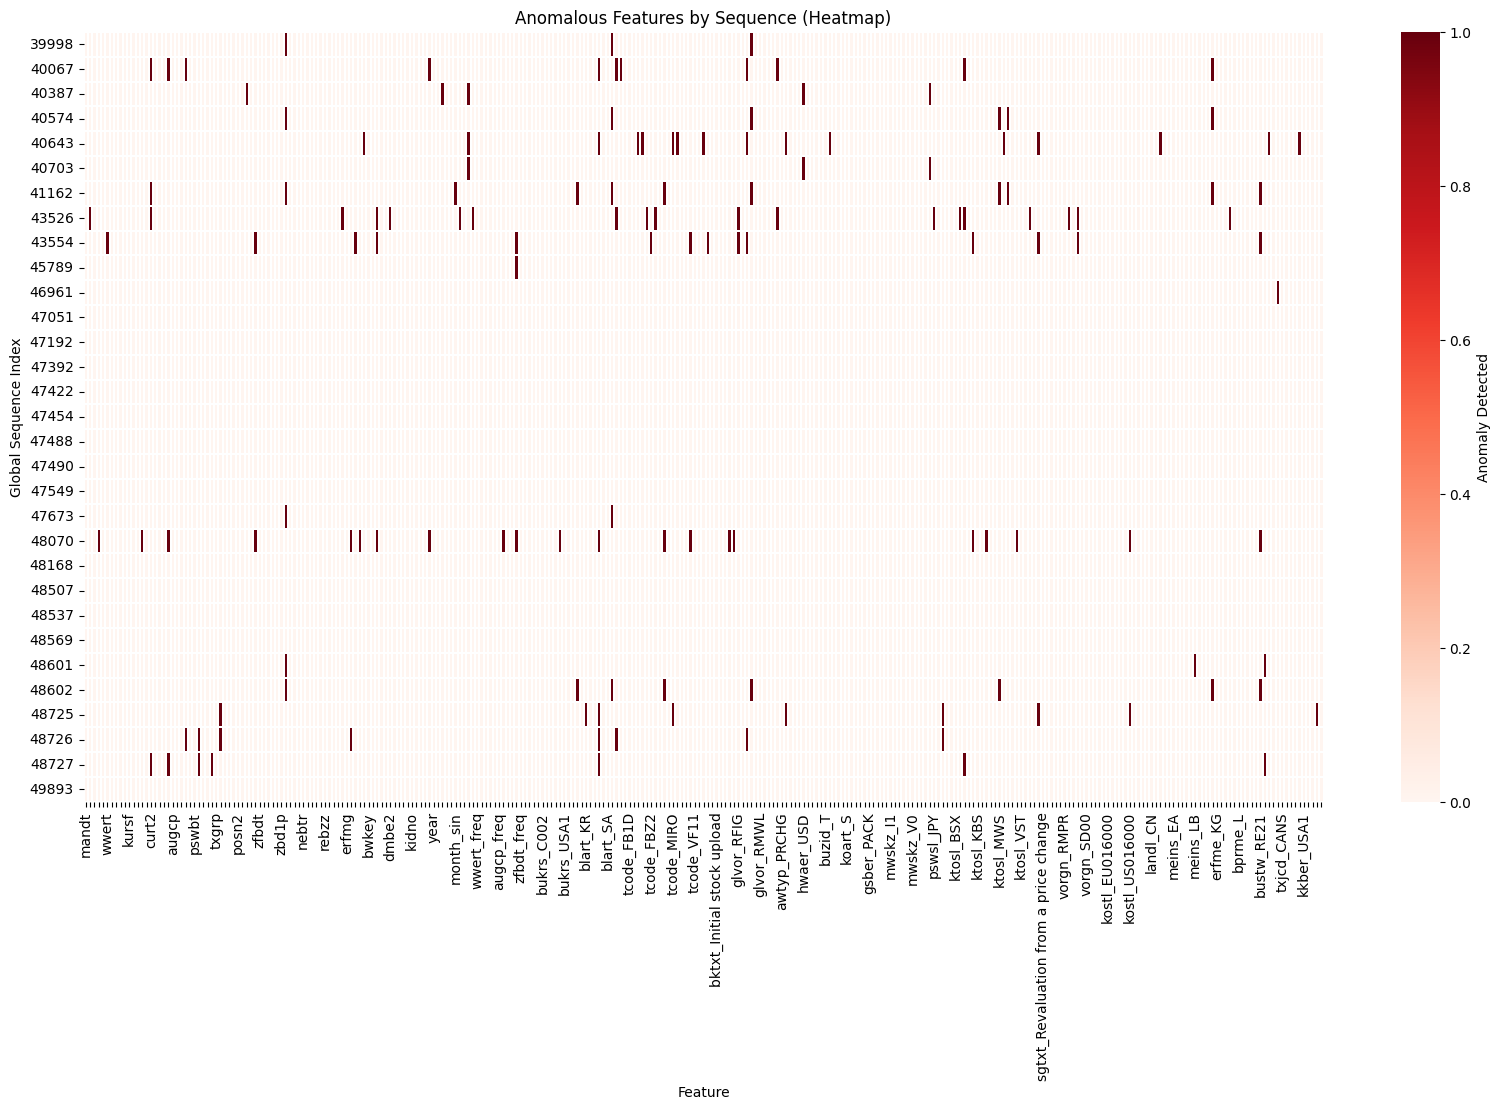

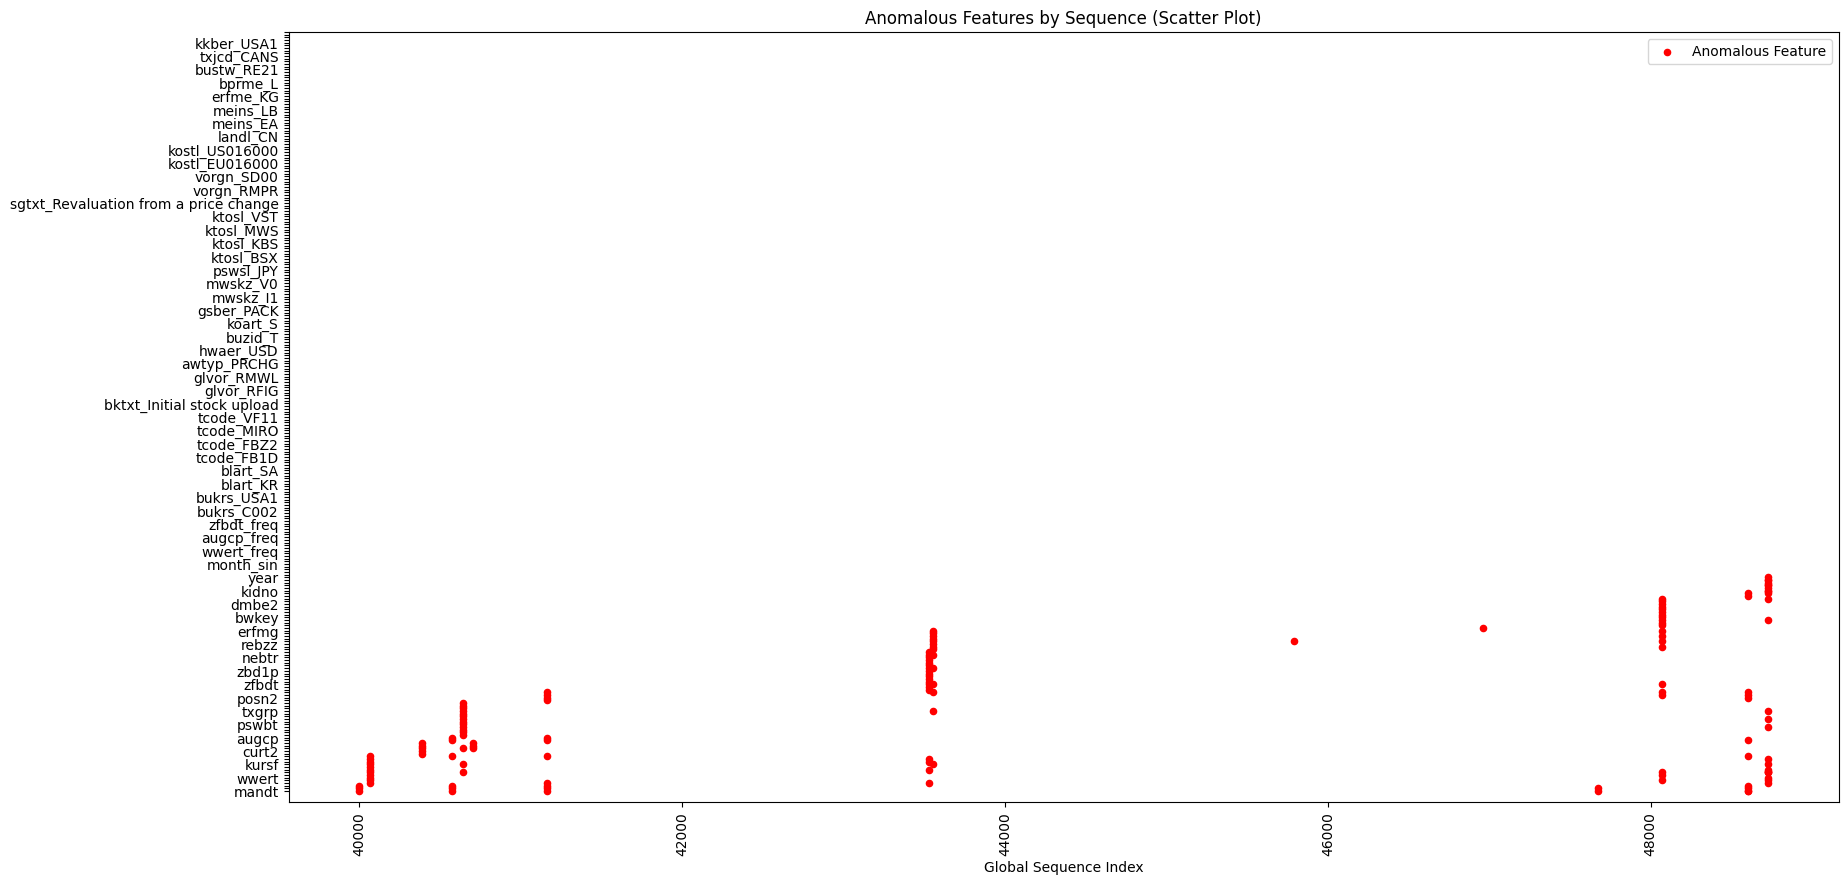

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -------------------------------
# 1) Load data and feature names
# -------------------------------
# Load original data to extract feature names
data_path = "/Users/User2/Desktop/Research Seminar/timegan_processed_data.csv"
original_data = pd.read_csv(data_path).iloc[:50000]  # Keep as DataFrame to get column names
feature_names = list(original_data.columns)

# -------------------------------
# 2) Convert anomaly data into a matrix format
# -------------------------------
# Create an empty matrix of shape (num_sequences, num_features)
anomaly_matrix = np.zeros((len(anomaly_seq_indices), input_dim))

# Fill in the matrix with 1 where a feature is anomalous
for i, seq_idx in enumerate(anomaly_seq_indices):
    bad_features = anomalous_features_percentile.get(seq_idx, [])
    anomaly_matrix[i, bad_features] = 1

# -------------------------------
# 3) Create a Heatmap with Feature Names
# -------------------------------
plt.figure(figsize=(20, 10))  # Increase figure size to reduce clutter

# ✅ Show only every 5th feature label to reduce clutter
if len(feature_names) > 50:
    display_labels = [name if i % 5 == 0 else '' for i, name in enumerate(feature_names)]
else:
    display_labels = feature_names

sns.heatmap(
    anomaly_matrix,
    cmap="Reds",
    xticklabels=display_labels,  # Use reduced labels
    yticklabels=global_anomaly_seq_indices,
    cbar_kws={'label': 'Anomaly Detected'},
    linewidths=0.1
)

# ✅ Rotate labels by 90 degrees for better visibility
plt.xticks(rotation=90)

plt.title("Anomalous Features by Sequence (Heatmap)")
plt.xlabel("Feature")
plt.ylabel("Global Sequence Index")
plt.show()

# -------------------------------
# 4) Create a Scatter Plot with Feature Names
# -------------------------------
plt.figure(figsize=(20, 10))

# ✅ Convert feature indices to names
for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    feature_labels = [feature_names[f] for f in features]
    plt.scatter(
        [global_seq] * len(features),
        feature_labels,
        color='red',
        label='Anomalous Feature' if seq_idx == anomaly_seq_indices[0] else "",
        s=20
    )

plt.title("Anomalous Features by Sequence (Scatter Plot)")
plt.xlabel("Global Sequence Index")

# ✅ Show only every 5th label if too many features
if len(feature_names) > 50:
    display_labels = [name if i % 5 == 0 else '' for i, name in enumerate(feature_names)]
    plt.yticks(np.arange(len(display_labels)), display_labels)
else:
    plt.yticks(np.arange(len(feature_names)), feature_names)

plt.xticks(rotation=90)  # Rotate x-axis labels
plt.legend()
plt.show()

Per-feature thresholds (99.5%):
[3.87749122e-03 9.40488670e-04 2.06395156e-03 2.11335198e-03
 3.48404203e-03 5.64244273e-04 3.98781111e-03 3.87765002e-03
 4.60514760e-05 1.14100443e-07 1.92604165e-03 7.28769069e-05
 3.81558319e-03 1.29356028e-03 2.85164655e-05 6.52490572e-04
 4.98828702e-06 8.06878730e-05 2.51554745e-03 2.08250508e-04
 4.90267957e-03 4.36275013e-06 4.85056021e-03 1.23865065e-03
 6.51598018e-06 8.33862917e-07 3.17622268e-03 3.82453157e-03
 1.29617549e-03 9.47046987e-04 1.07867282e-05 3.58662730e-03
 3.91153128e-03 4.34461497e-03 1.34329272e-03 1.55510023e-06
 1.23283682e-03 1.01112562e-03 3.87741369e-03 2.45718473e-02
 9.57784955e-04 9.15692824e-04 8.43457925e-10 9.71494540e-05
 4.26488526e-05 1.23313487e-05 1.29006940e-03 2.71262453e-03
 3.54533720e-04 1.18889015e-05 2.00739242e-03 2.44959985e-03
 2.64657144e-03 8.26840872e-04 5.08818763e-04 9.61704085e-12
 6.66461330e-04 4.27297251e-03 9.13139287e-04 6.56838925e-04
 4.29611959e-04 2.39720437e-03 3.77396415e-03 1.42597

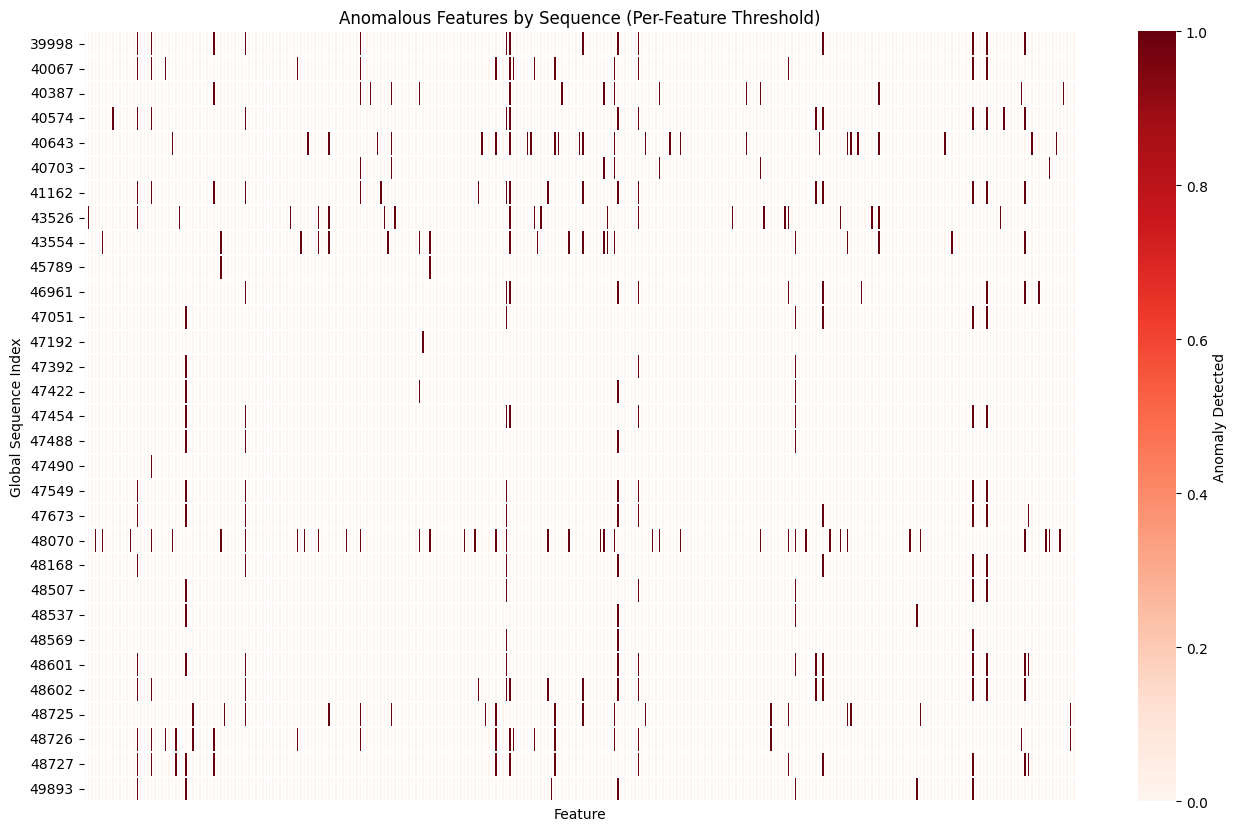

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Compute Per-Feature Thresholds (99.5% Each)
# -------------------------------
# Compute per-feature threshold based on the 99.5th percentile **per feature**
feature_thresholds = np.percentile(mean_feature_errors, 99.5, axis=0)  # shape = (input_dim,)
print(f"Per-feature thresholds (99.5%):\n{feature_thresholds}")

# -------------------------------
# 2) Identify Anomalous Features Based on Per-Feature Threshold
# -------------------------------
anomalous_features_percentile = {}

for i in anomaly_seq_indices:
    seq_errors = mean_feature_errors[i]  # Shape (input_dim,)
    
    # Identify which features exceed their respective threshold
    bad_features = np.where(seq_errors > feature_thresholds)[0]
    if len(bad_features) > 0:
        anomalous_features_percentile[i] = bad_features

# -------------------------------
# 3) Print Results
# -------------------------------
print("\nAnomalous features in each anomalous sequence (percentile-based):")
for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    print(f"Global sequence {global_seq}: anomalous feature indices: {features}")

# -------------------------------
# 4) Plot Results
# -------------------------------
# Create an empty matrix of shape (num_sequences, num_features)
anomaly_matrix = np.zeros((len(anomalous_features_percentile), mean_feature_errors.shape[1]))

for i, seq_idx in enumerate(anomalous_features_percentile):
    bad_features = anomalous_features_percentile[seq_idx]
    anomaly_matrix[i, bad_features] = 1

plt.figure(figsize=(16, 10))
sns.heatmap(
    anomaly_matrix,
    cmap="Reds",
    xticklabels=feature_names if len(feature_names) <= 50 else False,
    yticklabels=global_anomaly_seq_indices,
    cbar_kws={'label': 'Anomaly Detected'},
    linewidths=0.1
)

plt.title("Anomalous Features by Sequence (Per-Feature Threshold)")
plt.xlabel("Feature")
plt.ylabel("Global Sequence Index")
plt.show()


Adjusted per-feature thresholds (percentile + MAD):
[3.87762394e-03 1.08537169e-03 2.43533399e-03 2.71207895e-03
 3.70599654e-03 7.25242822e-04 3.98937155e-03 3.87771707e-03
 5.82334008e-05 1.59930719e-07 2.38608578e-03 1.03664998e-04
 3.81564326e-03 1.91832871e-03 3.70235578e-05 7.44382642e-04
 6.81297373e-06 9.68703667e-05 2.88831199e-03 3.10303570e-04
 6.06775434e-03 5.69025224e-06 6.78315048e-03 1.73484872e-03
 1.01202376e-05 1.15065260e-06 3.35093320e-03 4.56049434e-03
 1.56338625e-03 1.07325012e-03 1.50211014e-05 4.06246142e-03
 7.47505248e-03 4.38899482e-03 1.57704963e-03 1.71128599e-06
 1.43373445e-03 1.32863997e-03 3.87746212e-03 2.45763868e-02
 1.13118984e-03 1.26532229e-03 9.23787724e-10 1.30309751e-04
 7.06058576e-05 1.29842471e-05 1.43721287e-03 3.32985088e-03
 4.47152186e-04 1.40717775e-05 2.49465218e-03 2.96350627e-03
 3.10453314e-03 9.56456964e-04 5.51912783e-04 1.30324876e-11
 8.03038563e-04 4.69524895e-03 1.11130220e-03 7.91049100e-04
 5.43588780e-04 2.87354205e-03 4.

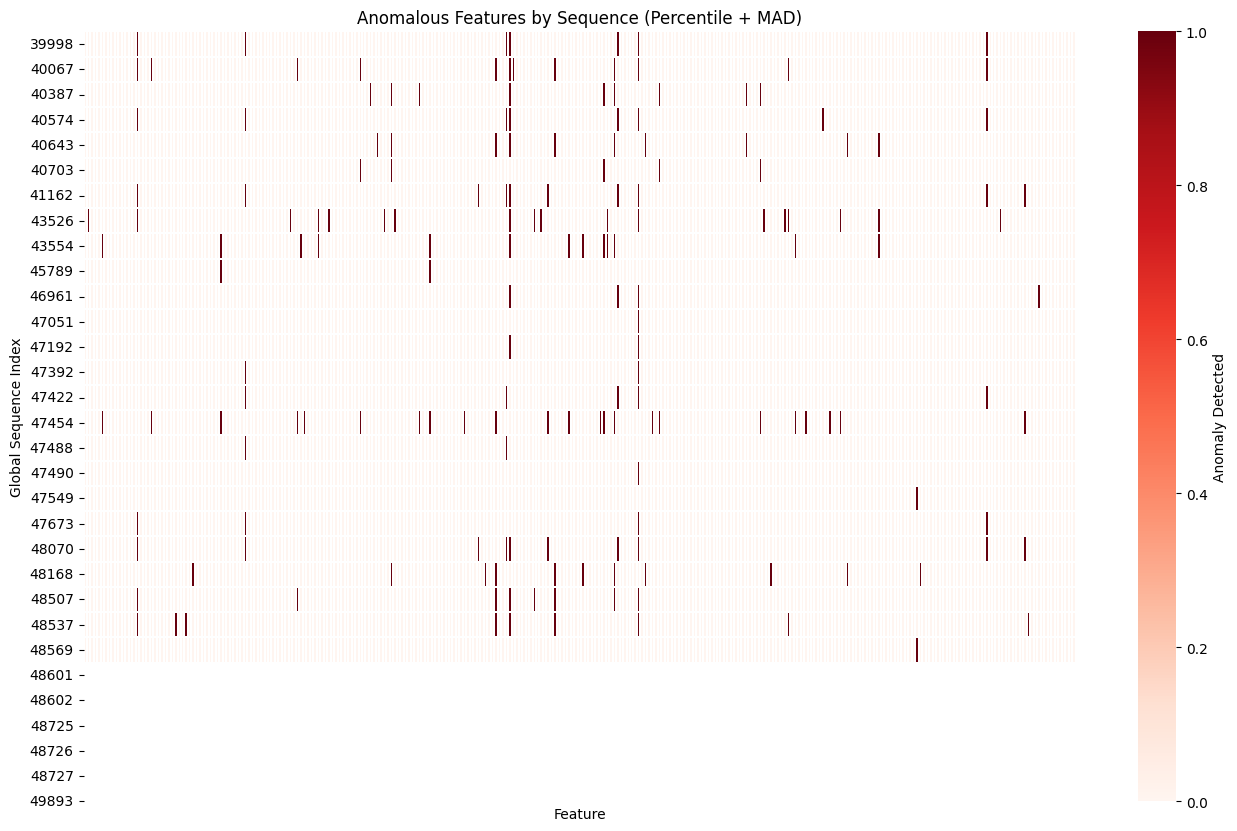

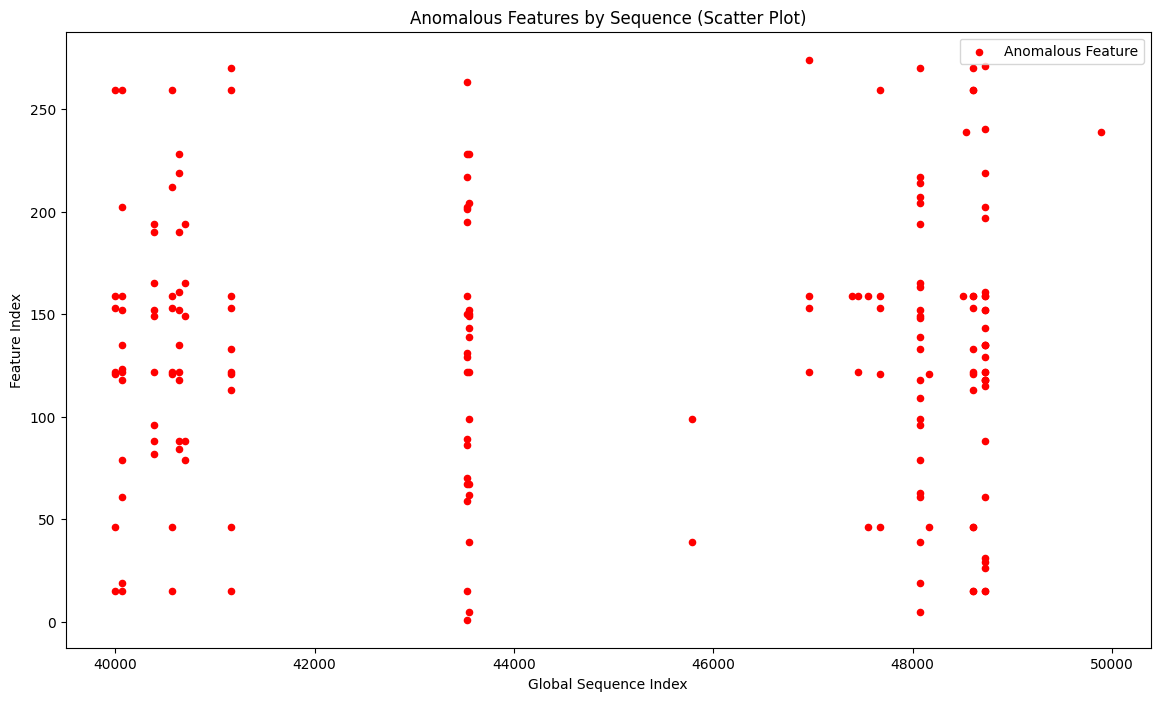

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Compute Mixed Thresholds (Percentile + MAD)
# -------------------------------
percentile = 99.5  # Drop from 99.5% to 99.0%
scaling_factor = 2.0  # Scale based on MAD

# Compute per-feature percentile threshold
feature_thresholds = np.percentile(mean_feature_errors, percentile, axis=0)

# Compute per-feature MAD (Median Absolute Deviation)
mad = np.median(np.abs(mean_feature_errors - np.median(mean_feature_errors, axis=0)), axis=0)

# Final mixed threshold = percentile + scaling * MAD
adjusted_thresholds = feature_thresholds + scaling_factor * mad

print(f"Adjusted per-feature thresholds (percentile + MAD):\n{adjusted_thresholds}")

# -------------------------------
# 2) Identify Anomalous Features
# -------------------------------
anomalous_features_percentile = {}

for i in anomaly_seq_indices:
    seq_errors = mean_feature_errors[i]  # Shape = (input_dim,)
    
    # Identify which features exceed their adjusted threshold
    bad_features = np.where(seq_errors > adjusted_thresholds)[0]
    
    if len(bad_features) > 0:
        anomalous_features_percentile[i] = bad_features

# -------------------------------
# 3) Print Results
# -------------------------------
print("\nAnomalous features in each anomalous sequence (percentile + MAD):")
for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    print(f"Global sequence {global_seq}: anomalous feature indices: {features}")

# -------------------------------
# 4) Plot Heatmap
# -------------------------------
# Create an empty matrix of shape (num_sequences, num_features)
anomaly_matrix = np.zeros((len(anomalous_features_percentile), mean_feature_errors.shape[1]))

for i, seq_idx in enumerate(anomalous_features_percentile):
    bad_features = anomalous_features_percentile[seq_idx]
    anomaly_matrix[i, bad_features] = 1

plt.figure(figsize=(16, 10))
sns.heatmap(
    anomaly_matrix,
    cmap="Reds",
    xticklabels=feature_names if len(feature_names) <= 50 else False,
    yticklabels=global_anomaly_seq_indices,
    cbar_kws={'label': 'Anomaly Detected'},
    linewidths=0.1
)

plt.title("Anomalous Features by Sequence (Percentile + MAD)")
plt.xlabel("Feature")
plt.ylabel("Global Sequence Index")
plt.show()

# -------------------------------
# 5) Plot Scatter Plot
# -------------------------------
plt.figure(figsize=(14, 8))

for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    plt.scatter(
        [global_seq] * len(features), 
        features, 
        color='red', 
        label='Anomalous Feature' if seq_idx == anomaly_seq_indices[0] else "",
        s=20
    )

plt.title("Anomalous Features by Sequence (Scatter Plot)")
plt.xlabel("Global Sequence Index")

# ✅ Replace numeric y-axis with feature names if available
if len(feature_names) <= 50:
    plt.yticks(np.arange(len(feature_names)), feature_names)
else:
    plt.ylabel("Feature Index")

plt.legend()
plt.show()

Adjusted per-feature thresholds (percentile + MAD):
[3.87768820e-03 1.03203187e-03 2.53959306e-03 2.89241757e-03
 2.04130140e-03 7.77625615e-04 3.93057694e-03 3.87774501e-03
 6.05166773e-05 1.81364580e-07 2.50137027e-03 1.16421089e-04
 3.81566770e-03 2.17986588e-03 4.12697849e-05 7.25711657e-04
 7.63714350e-06 1.04264337e-04 2.74296188e-03 3.51178754e-04
 6.59249410e-03 6.34863059e-06 6.96749056e-03 1.96353304e-03
 1.17813374e-05 1.30867779e-06 3.40386229e-03 4.48917405e-03
 1.61579372e-03 1.06184057e-03 1.71188756e-05 4.17776268e-03
 9.25210155e-03 4.37960808e-03 1.60681410e-03 1.71594854e-06
 1.46787984e-03 1.44952446e-03 3.87748425e-03 2.29125745e-02
 1.03581338e-03 1.42460694e-03 9.62925422e-10 1.46399044e-04
 8.45360346e-05 1.32640614e-05 1.44941785e-03 3.01782919e-03
 4.88895973e-04 1.51361431e-05 2.67094603e-03 3.09518168e-03
 3.08679312e-03 9.95346738e-04 4.95777919e-04 1.46653540e-11
 8.50193086e-04 4.85105316e-03 1.16681418e-03 8.32934703e-04
 5.98033409e-04 2.89338492e-03 3.

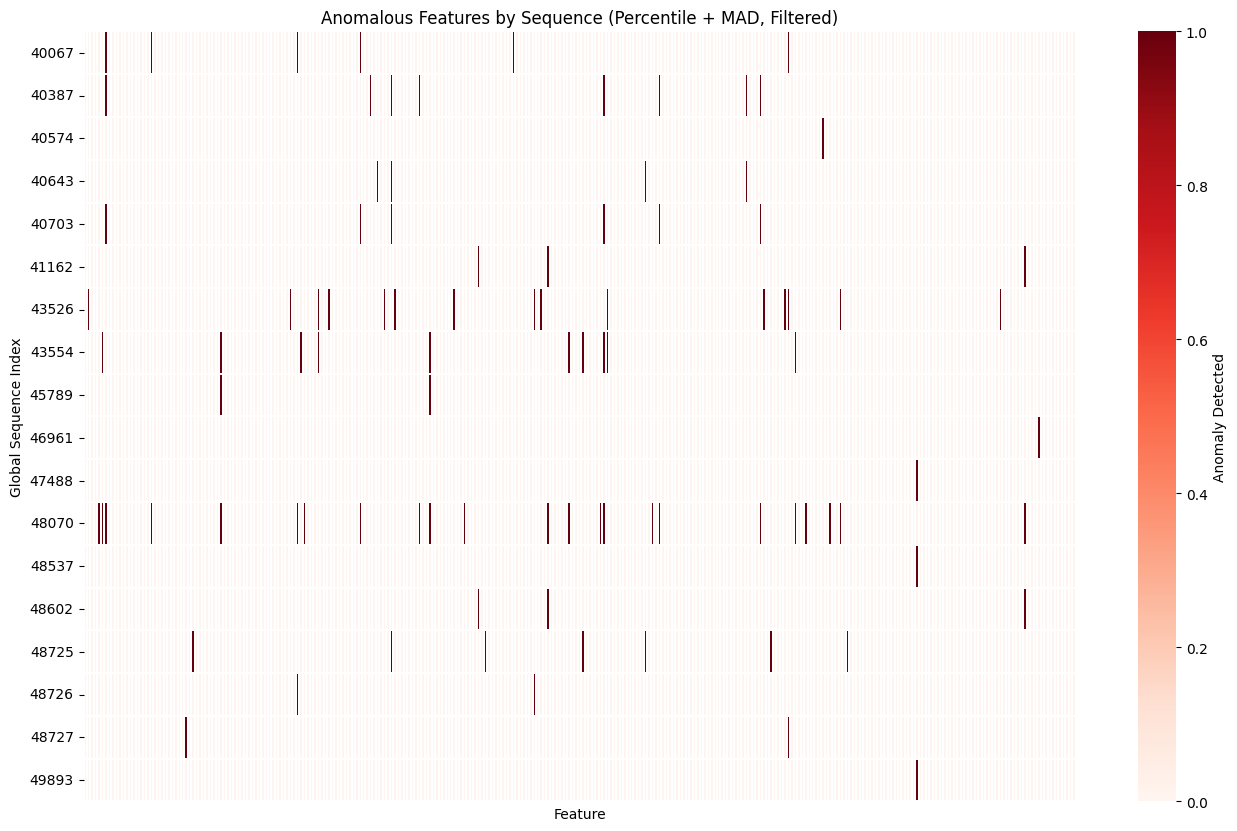

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


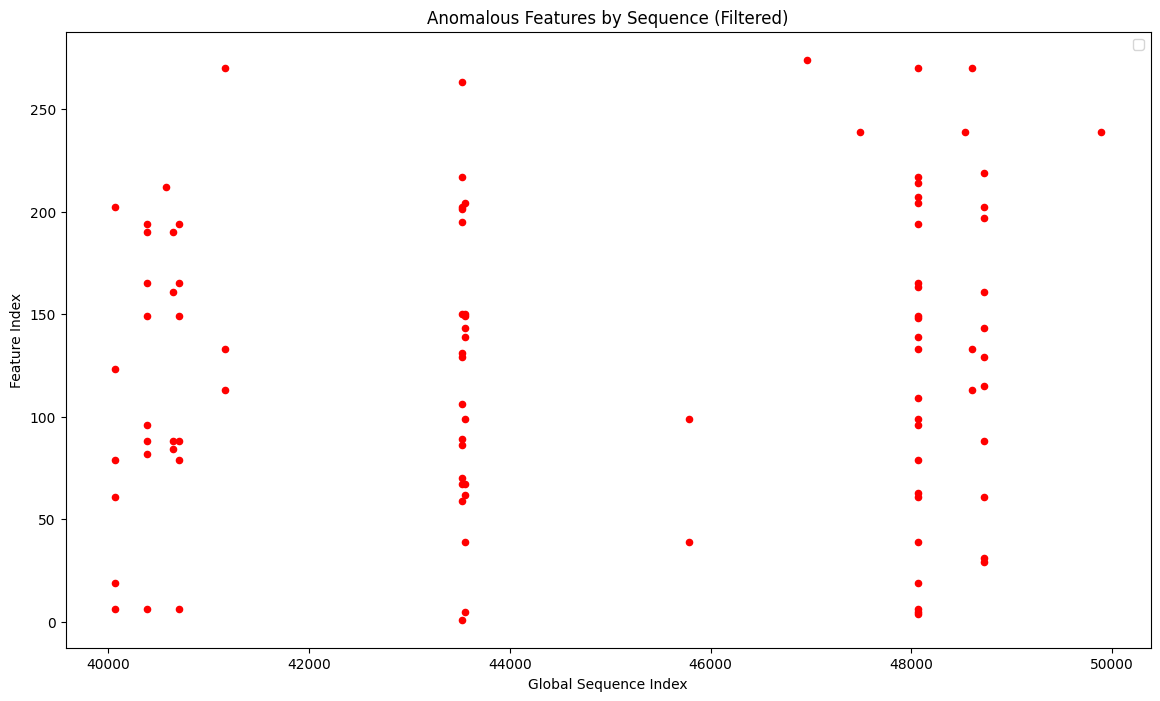

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Compute Mixed Thresholds (Percentile + MAD)
# -------------------------------
percentile = 99.0  # Lowered for stricter cutoff
scaling_factor = 3.0  # Increased MAD scaling to reduce noise
min_feature_flag_count = 5  # Require a feature to be flagged in at least 5 sequences

# Compute per-feature percentile threshold
feature_thresholds = np.percentile(mean_feature_errors, percentile, axis=0)

# Compute per-feature MAD (Median Absolute Deviation)
mad = np.median(np.abs(mean_feature_errors - np.median(mean_feature_errors, axis=0)), axis=0)

# Final mixed threshold = percentile + scaling * MAD
adjusted_thresholds = feature_thresholds + scaling_factor * mad

print(f"Adjusted per-feature thresholds (percentile + MAD):\n{adjusted_thresholds}")

# -------------------------------
# 2) Identify Anomalous Features
# -------------------------------
anomalous_features_percentile = {}

for i in anomaly_seq_indices:
    seq_errors = mean_feature_errors[i]  # Shape = (input_dim,)
    
    # Identify which features exceed their adjusted threshold
    bad_features = np.where(seq_errors > adjusted_thresholds)[0]
    
    if len(bad_features) > 0:
        anomalous_features_percentile[i] = bad_features

# -------------------------------
# 3) Apply Minimum Frequency Filter (Optional)
# -------------------------------
# Flatten all flagged features across sequences
all_flagged_features = np.concatenate(list(anomalous_features_percentile.values()))

# Count how often each feature was flagged
unique_features, feature_counts = np.unique(all_flagged_features, return_counts=True)

# Remove features that are flagged too often
filtered_features = unique_features[feature_counts < min_feature_flag_count]

# Filter out over-flagged features from the anomaly dictionary
for seq_idx in list(anomalous_features_percentile.keys()):
    anomalous_features_percentile[seq_idx] = [
        f for f in anomalous_features_percentile[seq_idx] if f in filtered_features
    ]
    
# Remove empty sequences (if filtering removes all features)
anomalous_features_percentile = {
    k: v for k, v in anomalous_features_percentile.items() if len(v) > 0
}

# -------------------------------
# 4) Print Results
# -------------------------------
print("\nAnomalous features in each anomalous sequence (percentile + MAD):")
for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    print(f"Global sequence {global_seq}: anomalous feature indices: {features}")

# -------------------------------
# 5) Plot Heatmap
# -------------------------------
# Create an empty matrix of shape (num_sequences, num_features)
anomaly_matrix = np.zeros((len(anomalous_features_percentile), mean_feature_errors.shape[1]))

for i, seq_idx in enumerate(anomalous_features_percentile):
    bad_features = anomalous_features_percentile[seq_idx]
    anomaly_matrix[i, bad_features] = 1

plt.figure(figsize=(16, 10))
sns.heatmap(
    anomaly_matrix,
    cmap="Reds",
    xticklabels=feature_names if len(feature_names) <= 50 else False,
    yticklabels=[test_start_seq + idx for idx in anomalous_features_percentile.keys()],
    cbar_kws={'label': 'Anomaly Detected'},
    linewidths=0.1
)

plt.title("Anomalous Features by Sequence (Percentile + MAD, Filtered)")
plt.xlabel("Feature")
plt.ylabel("Global Sequence Index")
plt.show()

# -------------------------------
# 6) Plot Scatter Plot
# -------------------------------
plt.figure(figsize=(14, 8))

for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    plt.scatter(
        [global_seq] * len(features), 
        features, 
        color='red', 
        label='Anomalous Feature' if seq_idx == anomaly_seq_indices[0] else "",
        s=20
    )

plt.title("Anomalous Features by Sequence (Filtered)")
plt.xlabel("Global Sequence Index")

# ✅ Replace numeric y-axis with feature names if available
if len(feature_names) <= 50:
    plt.yticks(np.arange(len(feature_names)), feature_names)
else:
    plt.ylabel("Feature Index")

plt.legend()
plt.show()


Adjusted per-feature thresholds (percentile + MAD):
[3.87762184e-03 9.59590353e-04 2.35390186e-03 2.59305412e-03
 1.93032416e-03 6.97126341e-04 3.92979673e-03 3.87771148e-03
 5.44257149e-05 1.58449442e-07 2.27134821e-03 1.01027043e-04
 3.81563767e-03 1.86748166e-03 3.70162391e-05 6.79765629e-04
 6.72480004e-06 9.61730897e-05 2.55657961e-03 3.00152216e-04
 6.00995672e-03 5.68487953e-06 6.00119543e-03 1.71543400e-03
 9.97920869e-06 1.15028295e-06 3.31650702e-03 4.12119267e-03
 1.48218834e-03 9.98738994e-04 1.50016888e-05 3.93984561e-03
 7.47034106e-03 4.35741816e-03 1.48993565e-03 1.63785566e-06
 1.36743102e-03 1.29076729e-03 3.87746003e-03 2.29103048e-02
 9.49110928e-04 1.24979219e-03 9.22760522e-10 1.29818894e-04
 7.05575340e-05 1.29376123e-05 1.37584612e-03 2.70921601e-03
 4.42586736e-04 1.40447051e-05 2.42731618e-03 2.83822844e-03
 2.85781227e-03 9.30538692e-04 4.74230905e-04 1.29576306e-11
 7.81904469e-04 4.63991494e-03 1.06773272e-03 7.65829608e-04
 5.41045002e-04 2.65521611e-03 3.

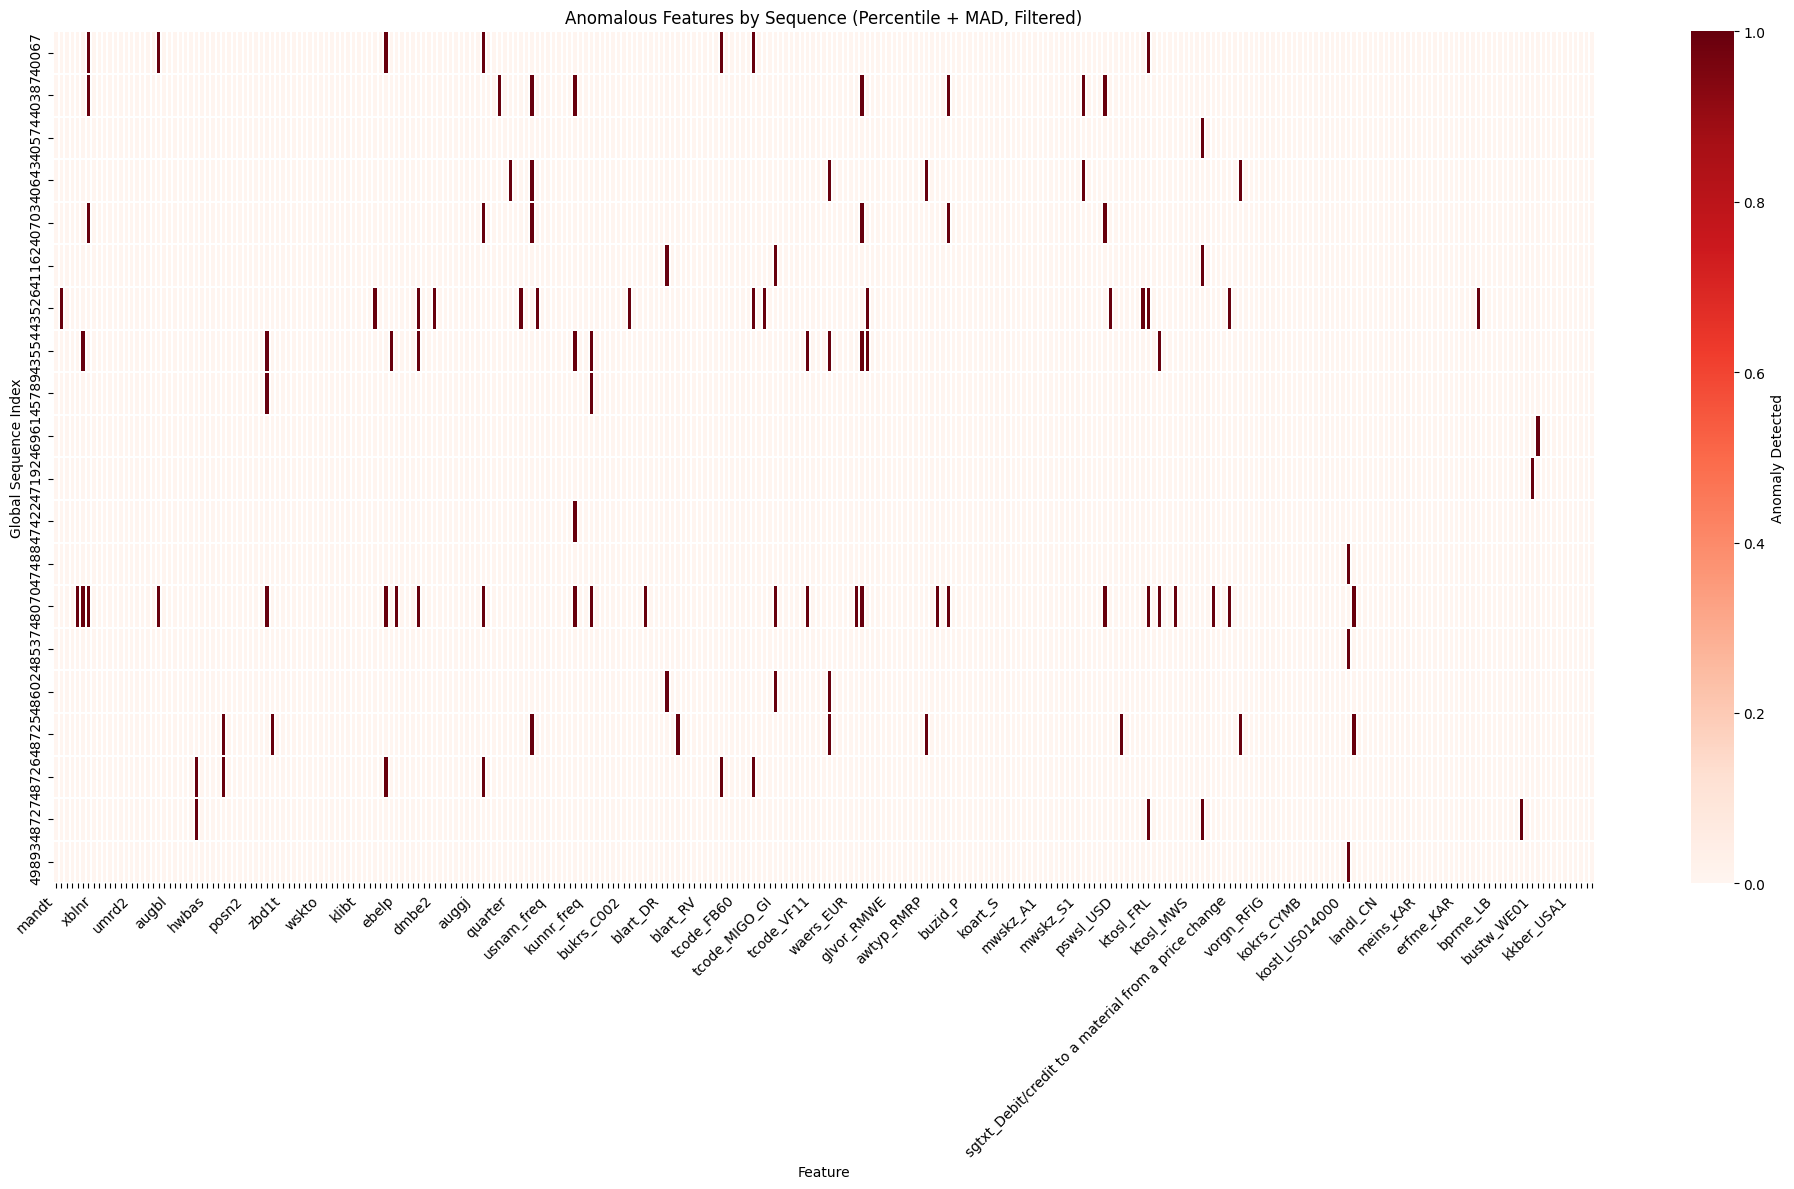

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


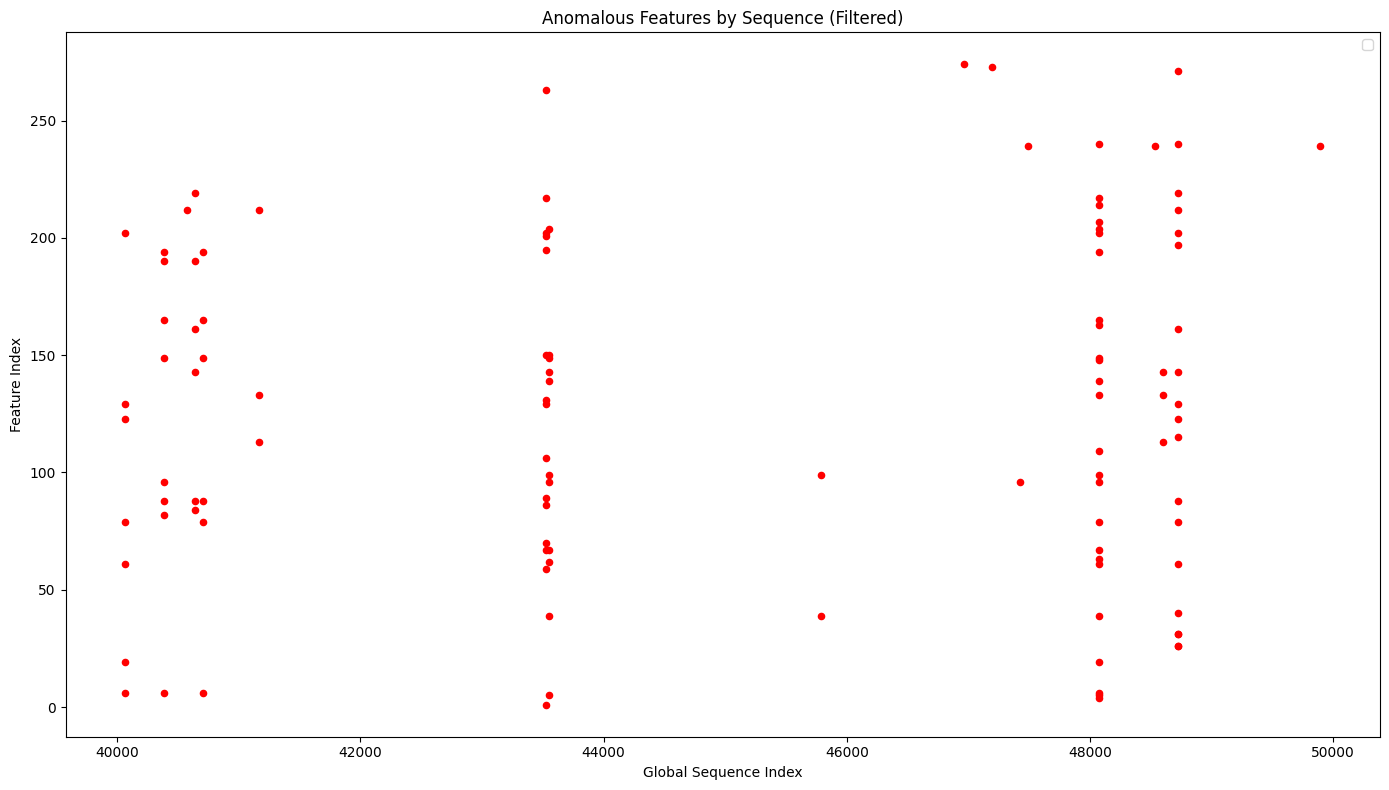

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Compute Mixed Thresholds (Percentile + MAD)
# -------------------------------
percentile = 99.0  # Lowered for stricter cutoff
scaling_factor = 2.0  # Increased MAD scaling to reduce noise
min_feature_flag_count = 5  # Require a feature to be flagged in at least 5 sequences

# Compute per-feature percentile threshold
feature_thresholds = np.percentile(mean_feature_errors, percentile, axis=0)

# Compute per-feature MAD (Median Absolute Deviation)
mad = np.median(np.abs(mean_feature_errors - np.median(mean_feature_errors, axis=0)), axis=0)

# Final mixed threshold = percentile + scaling * MAD
adjusted_thresholds = feature_thresholds + scaling_factor * mad

print(f"Adjusted per-feature thresholds (percentile + MAD):\n{adjusted_thresholds}")

# -------------------------------
# 2) Identify Anomalous Features
# -------------------------------
anomalous_features_percentile = {}

for i in anomaly_seq_indices:
    seq_errors = mean_feature_errors[i]  # Shape = (input_dim,)
    
    # Identify which features exceed their adjusted threshold
    bad_features = np.where(seq_errors > adjusted_thresholds)[0]
    
    if len(bad_features) > 0:
        anomalous_features_percentile[i] = bad_features

# -------------------------------
# 3) Apply Minimum Frequency Filter (Optional)
# -------------------------------
# Flatten all flagged features across sequences
all_flagged_features = np.concatenate(list(anomalous_features_percentile.values()))

# Count how often each feature was flagged
unique_features, feature_counts = np.unique(all_flagged_features, return_counts=True)

# Remove features that are flagged too often
filtered_features = unique_features[feature_counts < min_feature_flag_count]

# Filter out over-flagged features from the anomaly dictionary
for seq_idx in list(anomalous_features_percentile.keys()):
    anomalous_features_percentile[seq_idx] = [
        f for f in anomalous_features_percentile[seq_idx] if f in filtered_features
    ]
    
# Remove empty sequences (if filtering removes all features)
anomalous_features_percentile = {
    k: v for k, v in anomalous_features_percentile.items() if len(v) > 0
}

# -------------------------------
# 4) Compute Outlier Percentage
# -------------------------------
# Total number of test sequences
total_sequences = len(mean_feature_errors)

# Number of sequences with at least one flagged feature
outlier_sequences = len(anomalous_features_percentile)
outlier_rate_sequences = (outlier_sequences / total_sequences) * 100

# Total number of possible feature-sequence pairs
total_possible_features = total_sequences * mean_feature_errors.shape[1]

# Total number of flagged features
total_flagged_features = sum(len(features) for features in anomalous_features_percentile.values())
outlier_rate_features = (total_flagged_features / total_possible_features) * 100

# ✅ Display Results
print(f"\nOutlier Rate (Sequences): {outlier_rate_sequences:.4f}%")
print(f"Outlier Rate (Features): {outlier_rate_features:.4f}%")

# -------------------------------
# 5) Print Results
# -------------------------------
print("\nAnomalous features in each anomalous sequence (percentile + MAD):")
for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    feature_names_display = [feature_names[i] for i in features]
    print(f"Global sequence {global_seq}: anomalous features: {feature_names_display}")

# -------------------------------
# 6) Plot Heatmap (with feature names)
# -------------------------------
# Create an empty matrix of shape (num_sequences, num_features)
anomaly_matrix = np.zeros((len(anomalous_features_percentile), mean_feature_errors.shape[1]))

for i, seq_idx in enumerate(anomalous_features_percentile):
    bad_features = anomalous_features_percentile[seq_idx]
    anomaly_matrix[i, bad_features] = 1

plt.figure(figsize=(20, 12))  # Increased figure size

# Control how frequently x-ticks (feature names) are shown
xtick_step = max(1, len(feature_names) // 40)  # Show approximately 40 feature names

sns.heatmap(
    anomaly_matrix,
    cmap="Reds",
    xticklabels=[feature_names[i] if i % xtick_step == 0 else '' for i in range(len(feature_names))],
    yticklabels=[test_start_seq + idx for idx in anomalous_features_percentile.keys()],
    cbar_kws={'label': 'Anomaly Detected'},
    linewidths=0.1
)

# Rotate and align feature names
plt.xticks(rotation=45, ha='right')

plt.title("Anomalous Features by Sequence (Percentile + MAD, Filtered)")
plt.xlabel("Feature")
plt.ylabel("Global Sequence Index")

plt.tight_layout()
plt.show()

# -------------------------------
# 7) Plot Scatter Plot (with feature names)
# -------------------------------
plt.figure(figsize=(14, 8))

for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    plt.scatter(
        [global_seq] * len(features), 
        features, 
        color='red', 
        label='Anomalous Feature' if seq_idx == anomaly_seq_indices[0] else "",
        s=20
    )

plt.title("Anomalous Features by Sequence (Filtered)")
plt.xlabel("Global Sequence Index")

# ✅ Add feature names if reasonable number of features
if len(feature_names) <= 100:
    plt.yticks(np.arange(len(feature_names)), feature_names)
else:
    plt.ylabel("Feature Index")

plt.legend()
plt.tight_layout()
plt.show()

Adjusted per-feature thresholds (percentile + MAD):
[3.87762184e-03 9.59590353e-04 2.35390186e-03 2.59305412e-03
 1.93032416e-03 6.97126341e-04 3.92979673e-03 3.87771148e-03
 5.44257149e-05 1.58449442e-07 2.27134821e-03 1.01027043e-04
 3.81563767e-03 1.86748166e-03 3.70162391e-05 6.79765629e-04
 6.72480004e-06 9.61730897e-05 2.55657961e-03 3.00152216e-04
 6.00995672e-03 5.68487953e-06 6.00119543e-03 1.71543400e-03
 9.97920869e-06 1.15028295e-06 3.31650702e-03 4.12119267e-03
 1.48218834e-03 9.98738994e-04 1.50016888e-05 3.93984561e-03
 7.47034106e-03 4.35741816e-03 1.48993565e-03 1.63785566e-06
 1.36743102e-03 1.29076729e-03 3.87746003e-03 2.29103048e-02
 9.49110928e-04 1.24979219e-03 9.22760522e-10 1.29818894e-04
 7.05575340e-05 1.29376123e-05 1.37584612e-03 2.70921601e-03
 4.42586736e-04 1.40447051e-05 2.42731618e-03 2.83822844e-03
 2.85781227e-03 9.30538692e-04 4.74230905e-04 1.29576306e-11
 7.81904469e-04 4.63991494e-03 1.06773272e-03 7.65829608e-04
 5.41045002e-04 2.65521611e-03 3.

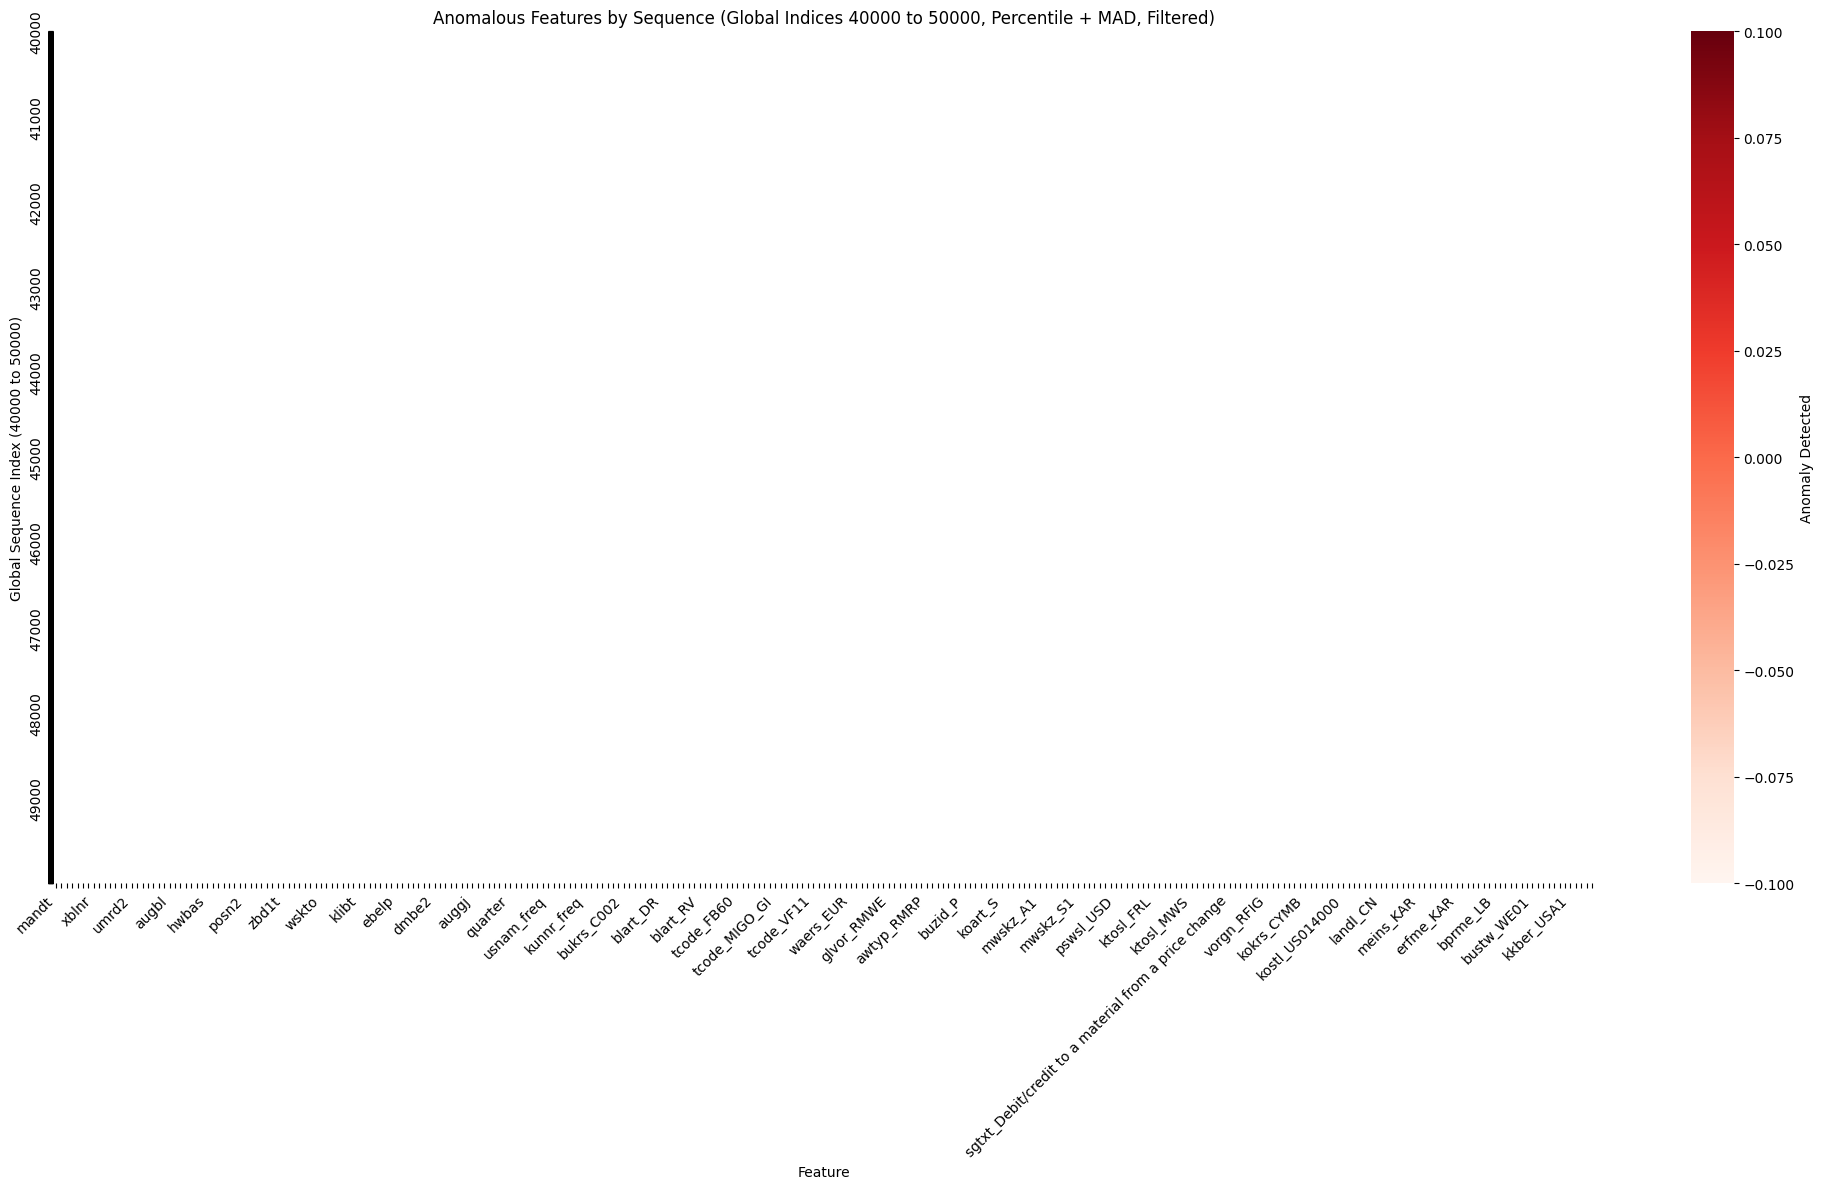

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


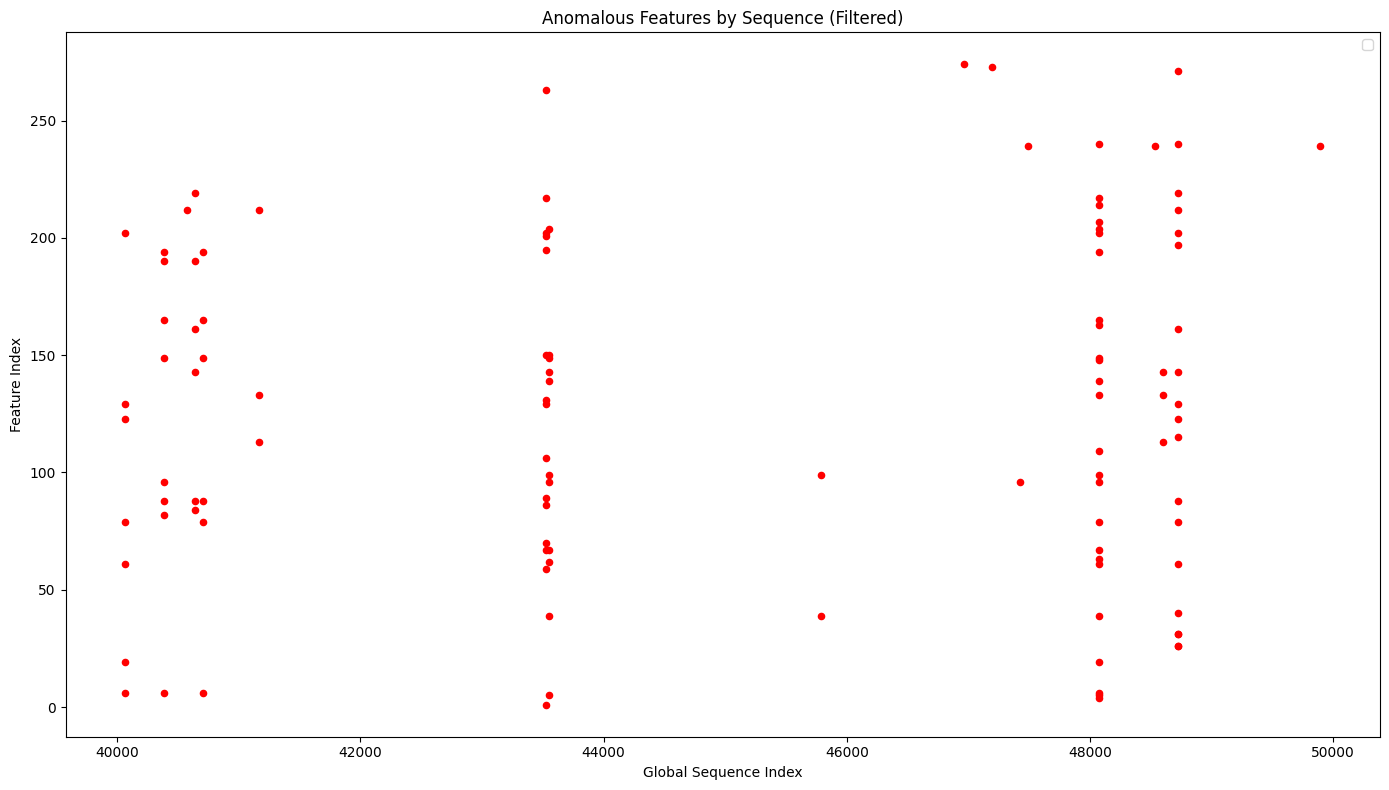

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Compute Mixed Thresholds (Percentile + MAD)
# -------------------------------
percentile = 99.0  # Lowered for stricter cutoff
scaling_factor = 2.0  # Increased MAD scaling to reduce noise
min_feature_flag_count = 5  # Require a feature to be flagged in at least 5 sequences

# Compute per-feature percentile threshold
feature_thresholds = np.percentile(mean_feature_errors, percentile, axis=0)

# Compute per-feature MAD (Median Absolute Deviation)
mad = np.median(np.abs(mean_feature_errors - np.median(mean_feature_errors, axis=0)), axis=0)

# Final mixed threshold = percentile + scaling * MAD
adjusted_thresholds = feature_thresholds + scaling_factor * mad

print(f"Adjusted per-feature thresholds (percentile + MAD):\n{adjusted_thresholds}")

# -------------------------------
# 2) Identify Anomalous Features
# -------------------------------
anomalous_features_percentile = {}

for i in anomaly_seq_indices:
    seq_errors = mean_feature_errors[i]  # Shape = (input_dim,)
    
    # Identify which features exceed their adjusted threshold
    bad_features = np.where(seq_errors > adjusted_thresholds)[0]
    
    if len(bad_features) > 0:
        anomalous_features_percentile[i] = bad_features

# -------------------------------
# 3) Apply Minimum Frequency Filter (Optional)
# -------------------------------
# Flatten all flagged features across sequences
all_flagged_features = np.concatenate(list(anomalous_features_percentile.values()))

# Count how often each feature was flagged
unique_features, feature_counts = np.unique(all_flagged_features, return_counts=True)

# Remove features that are flagged too often
filtered_features = unique_features[feature_counts < min_feature_flag_count]

# Filter out over-flagged features from the anomaly dictionary
for seq_idx in list(anomalous_features_percentile.keys()):
    anomalous_features_percentile[seq_idx] = [
        f for f in anomalous_features_percentile[seq_idx] if f in filtered_features
    ]
    
# Remove empty sequences (if filtering removes all features)
anomalous_features_percentile = {
    k: v for k, v in anomalous_features_percentile.items() if len(v) > 0
}

# -------------------------------
# 4) Compute Outlier Percentage
# -------------------------------
# Total number of test sequences
total_sequences = len(mean_feature_errors)

# Number of sequences with at least one flagged feature
outlier_sequences = len(anomalous_features_percentile)
outlier_rate_sequences = (outlier_sequences / total_sequences) * 100

# Total number of possible feature-sequence pairs
total_possible_features = total_sequences * mean_feature_errors.shape[1]

# Total number of flagged features
total_flagged_features = sum(len(features) for features in anomalous_features_percentile.values())
outlier_rate_features = (total_flagged_features / total_possible_features) * 100

# ✅ Display Results
print(f"\nOutlier Rate (Sequences): {outlier_rate_sequences:.4f}%")
print(f"Outlier Rate (Features): {outlier_rate_features:.4f}%")

# -------------------------------
# 5) Print Results
# -------------------------------
print("\nAnomalous features in each anomalous sequence (percentile + MAD):")
for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    feature_names_display = [feature_names[i] for i in features]
    print(f"Global sequence {global_seq}: anomalous features: {feature_names_display}")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 6) Plot Heatmap (with feature names)
# -------------------------------

# Create an empty matrix of shape (10000 sequences, num_features)
anomaly_matrix_full = np.zeros((10000, mean_feature_errors.shape[1]))

# Populate anomaly matrix based on detected anomalies
for seq_idx, bad_features in anomalous_features_percentile.items():
    local_index = seq_idx - 40000  # Convert global index to local index for this range
    if 0 <= local_index < 10000:
        anomaly_matrix_full[local_index, bad_features] = 1

plt.figure(figsize=(20, 12))

# Control how frequently x-ticks (feature names) are shown
xtick_step = max(1, len(feature_names) // 40)  # Show approximately 40 feature names

# Control how frequently y-ticks (global sequence index) are shown
ytick_step = 1000  # Show every 1000 sequences for clarity

sns.heatmap(
    anomaly_matrix_full,
    cmap="Reds",
    xticklabels=[feature_names[i] if i % xtick_step == 0 else '' for i in range(len(feature_names))],
    yticklabels=[40000 + i if i % ytick_step == 0 else '' for i in range(10000)],
    cbar_kws={'label': 'Anomaly Detected'},
    linewidths=0.1
)

# Rotate and align feature names
plt.xticks(rotation=45, ha='right')

plt.title("Anomalous Features by Sequence (Global Indices 40000 to 50000, Percentile + MAD, Filtered)")
plt.xlabel("Feature")
plt.ylabel("Global Sequence Index (40000 to 50000)")

plt.tight_layout()
plt.show()

# -------------------------------
# 7) Plot Scatter Plot (with feature names)
# -------------------------------
plt.figure(figsize=(14, 8))

for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    plt.scatter(
        [global_seq] * len(features), 
        features, 
        color='red', 
        label='Anomalous Feature' if seq_idx == anomaly_seq_indices[0] else "",
        s=20
    )

plt.title("Anomalous Features by Sequence (Filtered)")
plt.xlabel("Global Sequence Index")

# ✅ Add feature names if reasonable number of features
if len(feature_names) <= 100:
    plt.yticks(np.arange(len(feature_names)), feature_names)
else:
    plt.ylabel("Feature Index")

plt.legend()
plt.tight_layout()
plt.show()


Anomalous features in each anomalous sequence (dynamic + MAD):
Global sequence 39998: anomalous feature indices: [46, 212]
Global sequence 40067: anomalous feature indices: [61, 79, 202]
Global sequence 40387: anomalous feature indices: [82, 88, 149, 165, 228]
Global sequence 40574: anomalous feature indices: [46, 212]
Global sequence 40643: anomalous feature indices: [84, 88, 228]
Global sequence 40703: anomalous feature indices: [79, 88, 149, 165, 194]
Global sequence 41162: anomalous feature indices: [46, 113, 212, 223, 270]
Global sequence 43526: anomalous feature indices: [1, 15, 27, 59, 67, 70, 77, 86, 89, 129, 131, 150, 195, 201, 202, 217, 226, 228, 263]
Global sequence 43554: anomalous feature indices: [39, 62, 67, 99, 149, 204, 228]
Global sequence 45789: anomalous feature indices: [39, 99]
Global sequence 46961: anomalous feature indices: [223]
Global sequence 48070: anomalous feature indices: [39, 61, 63, 79, 96, 99, 109, 148, 149, 163, 165, 204, 207, 270]
Global sequence 4

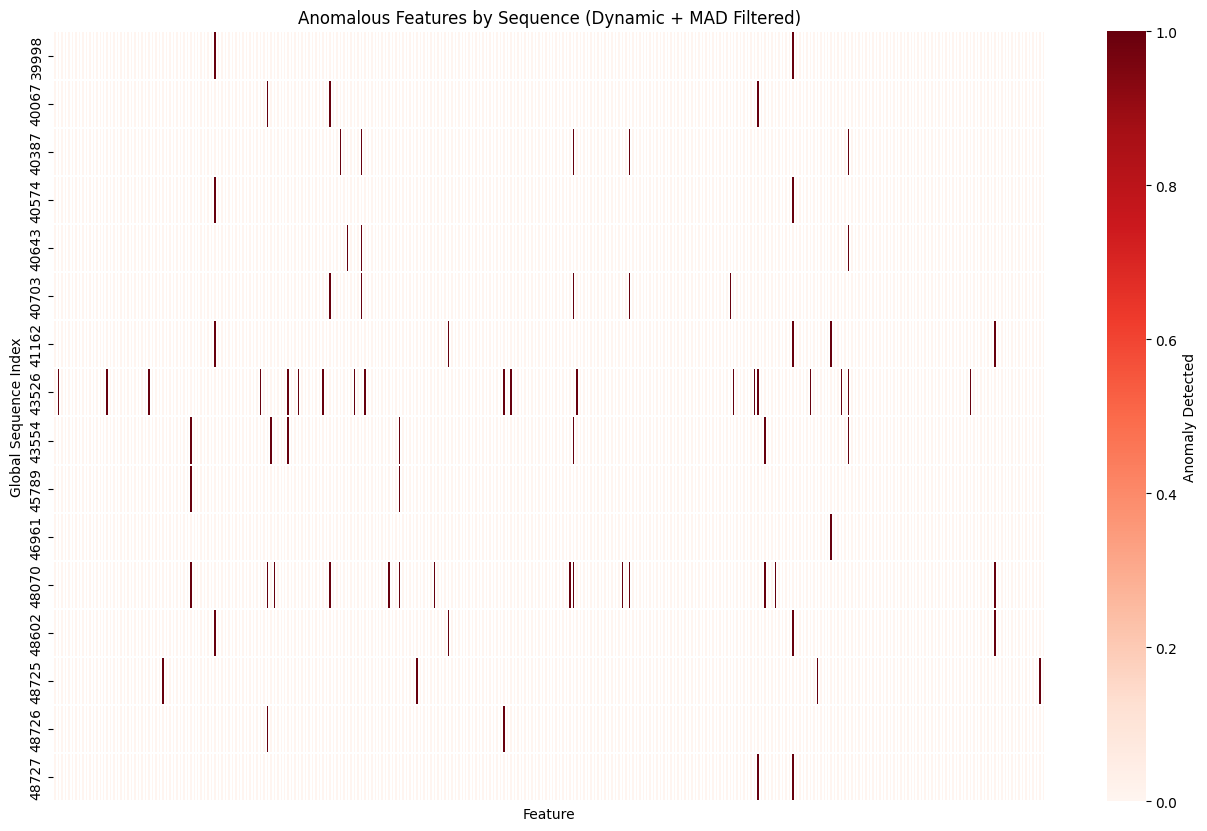

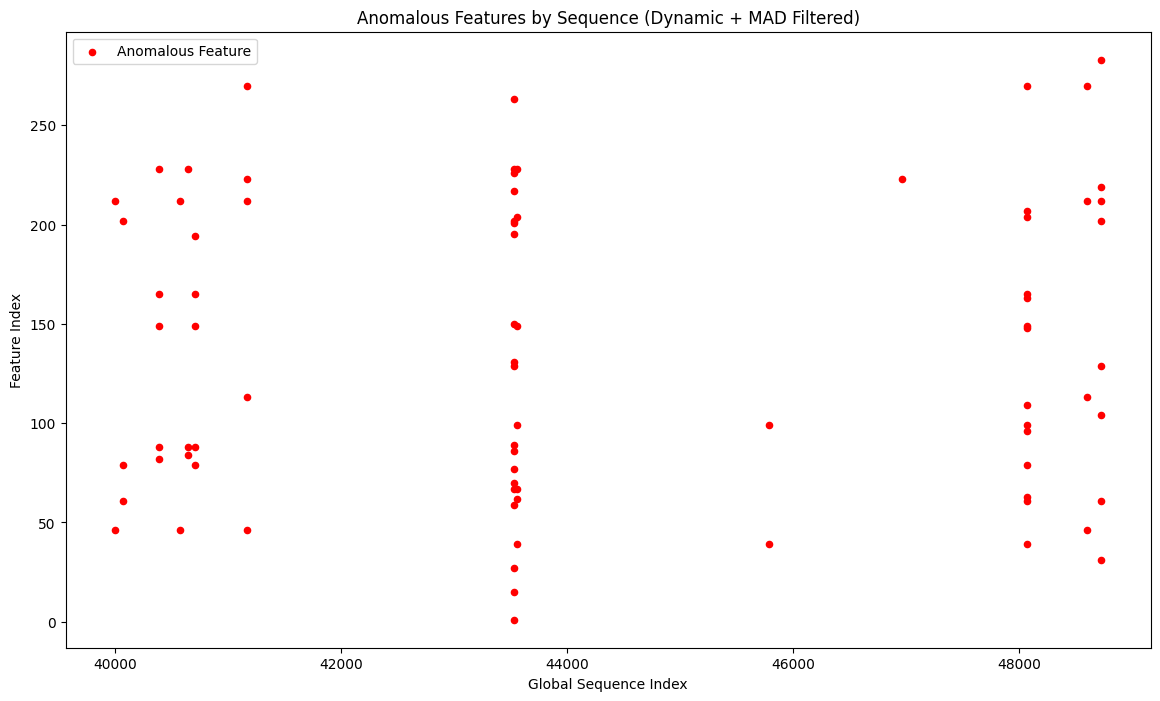

In [41]:
# -------------------------------
# 1) Adjust MAD Scaling + Dynamic Local Threshold
# -------------------------------
percentile = 99.0
global_scaling_factor = 3.5  # Increase slightly
local_scaling_factor = 2.0   # Dynamic within-sequence adjustment
min_feature_flag_count = 5   # Keep this

# Compute global thresholds using percentile + MAD
feature_thresholds = np.percentile(mean_feature_errors, percentile, axis=0)
mad = np.median(np.abs(mean_feature_errors - np.median(mean_feature_errors, axis=0)), axis=0)
adjusted_thresholds = feature_thresholds + global_scaling_factor * mad

# -------------------------------
# 2) Identify Anomalous Features Based on Local + Global Threshold
# -------------------------------
anomalous_features_percentile = {}

for i in anomaly_seq_indices:
    seq_errors = mean_feature_errors[i]  # Shape = (input_dim,)
    
    # Dynamic local thresholding (sequence-level MAD)
    local_mad = np.median(np.abs(seq_errors - np.median(seq_errors)))
    local_threshold = feature_thresholds + local_scaling_factor * local_mad
    
    # Identify which features exceed the combined threshold
    bad_features = np.where(seq_errors > local_threshold)[0]
    
    if len(bad_features) > 0:
        anomalous_features_percentile[i] = bad_features

# -------------------------------
# 3) Frequency-Based Filtering (Remove Over-Flagged Features)
# -------------------------------
# Flatten all flagged features across sequences
all_flagged_features = np.concatenate(list(anomalous_features_percentile.values()))

# Count how often each feature is flagged
unique_features, feature_counts = np.unique(all_flagged_features, return_counts=True)

# Ignore features flagged in >20% of sequences
max_allowed_count = int(len(anomaly_seq_indices) * 0.20)
filtered_features = unique_features[feature_counts < max_allowed_count]

# Remove over-flagged features
for seq_idx in list(anomalous_features_percentile.keys()):
    anomalous_features_percentile[seq_idx] = [
        f for f in anomalous_features_percentile[seq_idx] if f in filtered_features
    ]

# Remove empty sequences
anomalous_features_percentile = {
    k: v for k, v in anomalous_features_percentile.items() if len(v) > 0
}

# -------------------------------
# 4) Print Results
# -------------------------------
print("\nAnomalous features in each anomalous sequence (dynamic + MAD):")
for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    print(f"Global sequence {global_seq}: anomalous feature indices: {features}")

# -------------------------------
# 5) Plot Heatmap
# -------------------------------
# Create matrix for heatmap
anomaly_matrix = np.zeros((len(anomalous_features_percentile), mean_feature_errors.shape[1]))

for i, seq_idx in enumerate(anomalous_features_percentile):
    bad_features = anomalous_features_percentile[seq_idx]
    anomaly_matrix[i, bad_features] = 1

plt.figure(figsize=(16, 10))
sns.heatmap(
    anomaly_matrix,
    cmap="Reds",
    xticklabels=feature_names if len(feature_names) <= 50 else False,
    yticklabels=[test_start_seq + idx for idx in anomalous_features_percentile.keys()],
    cbar_kws={'label': 'Anomaly Detected'},
    linewidths=0.1
)

plt.title("Anomalous Features by Sequence (Dynamic + MAD Filtered)")
plt.xlabel("Feature")
plt.ylabel("Global Sequence Index")
plt.show()

# -------------------------------
# 6) Plot Scatter Plot
# -------------------------------
plt.figure(figsize=(14, 8))

for seq_idx, features in anomalous_features_percentile.items():
    global_seq = test_start_seq + seq_idx
    plt.scatter(
        [global_seq] * len(features), 
        features, 
        color='red', 
        label='Anomalous Feature' if seq_idx == anomaly_seq_indices[0] else "",
        s=20
    )

plt.title("Anomalous Features by Sequence (Dynamic + MAD Filtered)")
plt.xlabel("Global Sequence Index")

if len(feature_names) <= 50:
    plt.yticks(np.arange(len(feature_names)), feature_names)
else:
    plt.ylabel("Feature Index")

plt.legend()
plt.show()


In [15]:
# Assume these variables are already defined:
# all_errors: shape (N, seq_len, input_dim)
# feature_thresholds: fixed threshold for each feature, shape (input_dim,)
# anomalous_seq_indices: array of sequence indices flagged as anomalous by time-based detector

anomalous_seq_indices = np.where(time_anomalies)[0]  # from your time-based detection
anomalous_features_fixed = {}  # Dictionary: sequence index -> list of anomalous feature indices

for i in anomalous_seq_indices:
    seq_errors = all_errors[i]  # shape (seq_len, input_dim)
    mean_feature_error = np.mean(seq_errors, axis=0)  # shape (input_dim,)
    
    # For fixed thresholds, check which features exceed threshold:
    bad_features = np.where(mean_feature_error > feature_thresholds)[0]
    anomalous_features_fixed[i] = bad_features

# Print the results:
for seq_idx, features in anomalous_features_fixed.items():
    print(f"Sequence {seq_idx}: Anomalous Features (Fixed Threshold): {features}")

Sequence 10: Anomalous Features (Fixed Threshold): [  0   2   3   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57  59  60
  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78  79
  82  84  85  86  89  90  91  92  93  95  96  97  98  99 100 101 102 103
 104 105 106 107 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 130 132 133 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 150 151 152 153 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 185 186 187 188 189 190 191 192 193 194 195 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 250 251 252 253 254 255 256 257


In [17]:
import numpy as np

# -------------------------------
# Assume these variables are defined:
# all_errors: shape (N, seq_len, input_dim)
# time_anomalies: boolean array of shape (N,) indicating sequences flagged as anomalous by time-based detector
# For demonstration, let's assume these are already computed by your evaluation pipeline.
# -------------------------------

# First, compute the per-feature average reconstruction error for each sequence.
# This collapses the seq_len dimension by averaging over time steps.
error_feature = np.mean(all_errors, axis=1)  # shape: (N, input_dim)

# We'll now compute dynamic (rolling) thresholds for each feature.
# The idea is: for each feature j, for each sequence i, we look at a local window of sequences
# and compute a threshold based on the local median and MAD of the error for that feature.

rolling_window_feature = 50   # number of sequences to include on each side (you can adjust this)
k_feature_dynamic = 3.0       # scaling factor for the threshold

# Get the number of sequences (N) and the number of features (D)
N, D = error_feature.shape

# Initialize an array to store dynamic thresholds for each sequence and feature.
dynamic_thresholds = np.zeros((N, D))

# For each feature j and for each sequence i, compute a dynamic threshold.
for j in range(D):
    for i in range(N):
        # Define a rolling window around sequence i
        left = max(0, i - rolling_window_feature)
        right = min(N, i + rolling_window_feature + 1)  # +1 because slice end is exclusive
        window_data = error_feature[left:right, j]  # Errors for feature j in the window
        
        # Optionally, you can clip extreme values to reduce their influence.
        # For example, clip at the 99.5th percentile:
        clip_val = np.percentile(window_data, 99.5)
        clipped = np.clip(window_data, 0, clip_val)
        
        # Compute the median and Median Absolute Deviation (MAD) of the window
        median_val = np.median(clipped)
        mad_val = np.median(np.abs(clipped - median_val))
        
        # Define the dynamic threshold for feature j at sequence i
        dynamic_thresholds[i, j] = median_val + k_feature_dynamic * mad_val

# Now, for each sequence, compare the per-feature average error to the corresponding dynamic threshold.
# This will yield a boolean flag for each feature.
feature_anomaly_flags = error_feature > dynamic_thresholds  # shape: (N, D)

# Next, restrict our analysis only to the sequences flagged by the time-based detector.
anomalous_seq_indices = np.where(time_anomalies)[0]

# For each anomalous sequence, record which features are flagged.
anomalous_features_dynamic = {}  # Dictionary: key = sequence index, value = array of anomalous feature indices

for i in anomalous_seq_indices:
    # For sequence i, find the features that exceed their dynamic threshold.
    bad_features = np.where(feature_anomaly_flags[i])[0]
    anomalous_features_dynamic[i] = bad_features

# Print out the results.
print("Anomalous Features in Time-Based Anomalous Sequences (Dynamic Thresholding):")
for seq_idx, features in anomalous_features_dynamic.items():
    print(f"Sequence {seq_idx}: Anomalous Feature Indices: {features}")

Anomalous Features in Time-Based Anomalous Sequences (Dynamic Thresholding):
Sequence 10: Anomalous Feature Indices: [  2  15  19  23  29  37  46  52  59  65  79 104 106 112 113 121 122 133
 137 143 153 159 193 195 204 210 212 220 232 255 259 263 264 270 274]
Sequence 79: Anomalous Feature Indices: [  1   4   6  13  15  19  23  27  29  34  58  61  79  80  81  86  88  90
  91  94 106 112 113 118 120 122 123 129 131 134 135 137 152 154 159 161
 170 178 188 191 195 202 212 217 226 228 232 255 259 260 263]
Sequence 399: Anomalous Feature Indices: [  4  21  25  37  40  45  57  62  64  82  88  96 101 121 122 128 140 149
 150 151 152 159 165 173 194 195 202 204 205 211 214 217 229 237 239 259
 261 265 269 271 272 277 279]
Sequence 586: Anomalous Feature Indices: [  2   8  15  19  21  23  25  29  45  46  52  54  57  64  65 101 106 112
 113 121 122 128 133 140 143 153 159 173 195 202 204 205 210 211 212 214
 223 229 232 237 255 259 263 264 270 271 272 274 279]
Sequence 655: Anomalous Feature In

In [4]:
# Increase k_feature to loosen the threshold
k_feature = 7.0

# Optionally reduce or remove clipping
clipped = np.clip(flattened, 0, np.percentile(flattened, 99.9))

# Compute MAD
median = np.median(clipped, axis=0)
mad = np.median(np.abs(clipped - median), axis=0)

# Diagnostic check
print("\nFeature MAD (first 10):", mad[:10])

# Set threshold using MAD
feature_thresholds = median + k_feature * mad

# Percentage-based violation requirement
threshold_ratio = 0.10  # Require 10% of points to exceed threshold

feature_anomalies = np.zeros(N, dtype=bool)

for i in range(N):
    seq_error = all_errors[i]
    above_thresh = seq_error > feature_thresholds[np.newaxis, :]
    
    # Require >10% of the points in the sequence to exceed the threshold
    if np.mean(above_thresh) > threshold_ratio:
        feature_anomalies[i] = True

print("\nFeature thresholds (first 10):", feature_thresholds[:10])


Feature MAD (first 10): [5.68434189e-14 9.57950251e-05 1.70161889e-04 3.11388925e-04
 3.24509805e-04 1.03141334e-04 1.49033876e-04 8.88178420e-14
 7.20578100e-06 7.77222791e-18]

Feature thresholds (first 10): [4.5474735e-13 7.7813515e-04 1.3782635e-03 2.5036943e-03 2.6837657e-03
 8.2992821e-04 1.2947917e-03 7.1054274e-13 5.8175789e-05 6.3239261e-17]


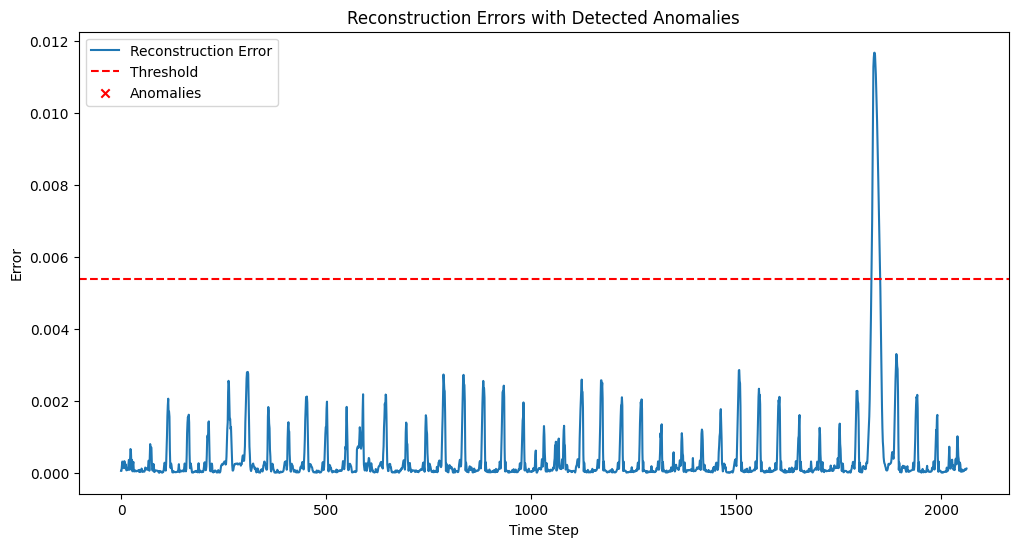

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the exported CSV
data = pd.read_csv('tadgan_test_results.csv')

# Plot reconstruction errors
plt.figure(figsize=(12, 6))
plt.plot(data['reconstruction_error'], label='Reconstruction Error')
plt.axhline(y=data['reconstruction_error'].quantile(0.99), color='red', linestyle='--', label='Threshold')
plt.scatter(data.index[data['anomaly'] == 1], data['reconstruction_error'][data['anomaly'] == 1],
            color='red', label='Anomalies', marker='x')
plt.title('Reconstruction Errors with Detected Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.legend()
plt.show()

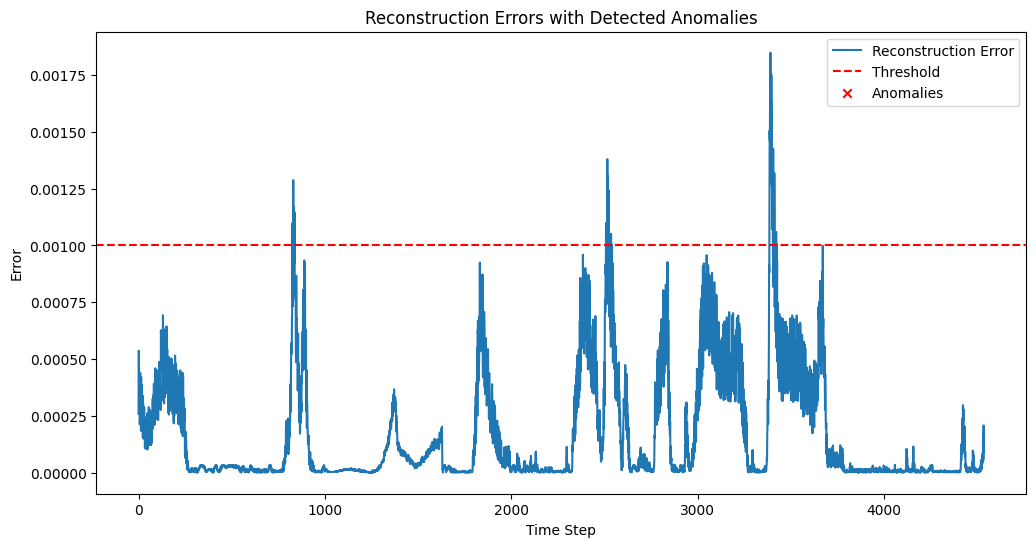

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the exported CSV
data = pd.read_csv('tadgan_test_results_machine_temp.csv')

# Plot reconstruction errors
plt.figure(figsize=(12, 6))
plt.plot(data['reconstruction_error'], label='Reconstruction Error')
plt.axhline(y=data['reconstruction_error'].quantile(0.99), color='red', linestyle='--', label='Threshold')
plt.scatter(data.index[data['anomaly'] == 1], data['reconstruction_error'][data['anomaly'] == 1],
            color='red', label='Anomalies', marker='x')
plt.title('Reconstruction Errors with Detected Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.legend()
plt.show()